In [361]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import seaborn as sns
sns.set()

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import glob, os, shutil
import re

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statistics import mean
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge

In [134]:
# Font sizes for the plots
FONT_SM  = 13
FONT_MED = 16
FONT_LG  = 20

## 1) Scraping Election Data

Election data is scraped from Turkish high election board's database, using Selenium package. Making a query in the database consists of 3 steps: 1) Query Options ("Sorgulama Secenekleri"), 2) Select Election Name ("Secim Adi Seciniz"), and 3) Election Results ("Secim Sonuclari"). 

Once the final step is reached, three dropdown lists (for filtering city, district and neighborhood name), and a filter for ballot box id appear. We are interested in neighborhood-wise election results. (Note: District is the subdivision of city, and neighborhood is the subdivision of district)

Due to database's design, when only a city is selected (but not a district) district-wise election results are shown
When both a city and district are selected, results of each ballot box (in the district) are shown. Hence, we will scrape the results by selecting both the city and district name, and then aggregating the ballot box results by neighborhood names.

In [26]:
database_url = 'https://sonuc.ysk.gov.tr'
istanbul = 'İSTANBUL'

# Election names
ist_reelect = 'İSTANBUL BÜYÜKŞEHİR BELEDİYE BAŞKANLIĞI YENİLEME SEÇİMİ (23/06/2019)'
loc_2019 = '31 MART 2019 MAHALLİ İDARELER GENEL SEÇİMİ (31/03/2019)'
gen_2018 = 'CUMHURBAŞKANI VE 27.DÖNEM MİLLETVEKİLİ GENEL SEÇİMİ (24/06/2018)'
ref_2017 = '2017 HALKOYLAMASI (16/04/2017)'
gen_nov_2015 = '26.DÖNEM MİLLETVEKİLİ GENEL SEÇİMİ (01/11/2015)'
gen_jun_2015 = '25.DÖNEM MİLLETVEKİLİ GENEL SEÇİMİ (07/06/2015)'

In [27]:
# Creates a webdriver object for Chrome and navigates to Turkish high election board's election results database
chrome = webdriver.Chrome(executable_path='/Users/ercansen/Dropbox/apps/chromedriver_mac64')
chrome.get(database_url)

In [28]:
# Website prompts the user to pick how to query the results; query by election name (third button) is selected
byElecNm_classname = 'ma-0.pa-0.border-0.cursor-pointer.w-100'

buttons_intro = list()
buttons_intro = chrome.find_elements_by_class_name(byElecNm_classname)
button_byElecNm = buttons_intro[2]
button_byElecNm.click()

In [29]:
# To open up the dropdown list of past 11 elections in Turkey, scans the corresponding arrow
elec_arrow_xpath = "//*[@id='collapsePanelThree']/div[1]/div/div/form/div[1]/div/div/ng-select/div/span"
elec_arrow = chrome.find_element_by_xpath(elec_arrow_xpath)

### Istanbul 2019 Mayoral Rerun Election

In [6]:
# Clicks elec_arrow so that the dropdown list is opened; desired election is selected from the list
elec_arrow.click()

for option in chrome.find_elements_by_class_name('ng-option'):
    if option.text == ist_reelect:
        option.click()
        break

In [7]:
# Clicks the green 'continue' ("Devam Et") button
continue_classname = 'btn.btn-success.rounded-0.mr-5'

button_continue = chrome.find_element_by_class_name(continue_classname)
button_continue.click()

In [8]:
# Clicks the corresponding arrow for city dropdown list
city_arrow_xpath = "//*[@id='collapsePanelFour']/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/div/span"
city_arrow = chrome.find_element_by_xpath(city_arrow_xpath)
city_arrow.click()

In [9]:
# Selects Istanbul from the list of cities (although it is the only option for the rerun mayoral election)
city_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/ng-dropdown-panel/div'
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul:
        option.click()
        break

In [18]:
# Scans the corresponding arrow for district dropdown list
district_arrow_xpath = "//*[@id='collapsePanelFour']/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/span"
district_arrow = chrome.find_element_by_xpath(district_arrow_xpath)

In [19]:
district_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/ng-dropdown-panel/div'
query_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[2]/div/div/button'
district_input_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/div/div[2]/input'
save_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/app-yurtici-muhtarlik-listesi/fieldset/div[2]/div/button'
accept_button_xpath = '/html/body/ngb-modal-window/div/div/div[2]/div/button[1]'

query_button = chrome.find_element_by_xpath(query_button_xpath)
district_input = chrome.find_element_by_xpath(district_input_xpath)

# Retrieves a list of districts of Istanbul
districts = list()
district_arrow.click()
for option in chrome.find_element_by_xpath(district_dropdown_xpath).find_elements_by_class_name('ng-option'):
    districts.append(option.text)

# For each district in the list, corresponding box receives district input, 
## navigates to election results and downloads them
for i in range(len(districts)):
    district = districts[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)   

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"/html/body/ngb-modal-window/div/div/div[2]/div/button[1]"}
  (Session info: chrome=83.0.4103.116)


In [13]:
# Creates directories in desired location in computer for storing the output excel files
downloads  = '/Users/ercansen/Downloads/'
dest_dir_1 = '/Users/ercansen/Desktop/apps/istanbul/2019-06' 
dest_dir_2 = '/Users/ercansen/Desktop/apps/istanbul/2019-06/raw'
os.mkdir(dest_dir_1)
os.mkdir(dest_dir_2)

# Queries all excel files with election results using glob
files = glob.glob(downloads + 'Yurt*.xlsx')

# Copies Excel files to the directory that was just created
for file in files:
    if os.path.isfile(file) and len(files) == 39:
        shutil.copy2(file, dest_dir_2)
        
# Deletes original files from 'Downloads' after copying
for file in files:
    if os.path.isfile(file) and len(files) == 39:
        os.remove(file)

### 2019 Local Election (cancelled)

In [14]:
# To select another election, we go back a step by clicking on 
## corresponding arrow for "Select Election Name"
elect_reselect_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[1]/div/div[2]/a/span'
chrome.find_element_by_xpath(elect_reselect_xpath).click()

# We make a new selection for election name
elec_arrow.click()
for option in chrome.find_elements_by_class_name('ng-option'):
    if option.text == loc_2019:
        option.click()
        break

In [19]:
# Scans election type arrow
elec_type_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[1]/div[2]/div/ng-select/div/span'
chrome.find_element_by_xpath(elec_type_arrow_xpath).click()

In [20]:
metro_municip_elec = 'BÜYÜKŞEHİR BELEDİYE BAŞKANLIĞI SEÇİMLERİ'
elec_type_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[1]/div[2]/div/ng-select/ng-dropdown-panel'
continue_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[2]/div/div/button[1]'

# At local elections, multiple elections are carried out (metropolitan mayor, district mayor, town council)
# We are interested in metro. mayor, since it is most suitable for our purposes, hence select that on dropdown list
elec_type_dropdown = chrome.find_element_by_xpath(elec_type_dropdown_xpath)

for option in elec_type_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == metro_municip_elec:
        option.click()
        break
        
time.sleep(5)
chrome.find_element_by_xpath(continue_xpath).click()

In [21]:
# Opens up the dropdown list for city name
city_arrow_xpath = "//*[@id='collapsePanelFour']/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/div/span"
city_arrow = chrome.find_element_by_xpath(city_arrow_xpath)
city_arrow.click()

In [22]:
# Selects Istanbul from the list of cities
city_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/ng-dropdown-panel/div'
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul:
        option.click()
        break

In [24]:
query_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[2]/div/div/button'
district_input_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/div/div[2]/input'
save_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/app-yurtici-muhtarlik-listesi/fieldset/div[2]/div/button'
accept_button_xpath = '/html/body/ngb-modal-window/div/div/div[2]/div/button[1]'

query_button = chrome.find_element_by_xpath(query_button_xpath)
district_input = chrome.find_element_by_xpath(district_input_xpath)

# We already have the list 'districts' from previous step
# Enters each district name to corresponding input box and downloads the election results
for i in range(len(districts)):
    district = districts[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    chrome.find_element_by_xpath(query_button_xpath).click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [25]:
# Creates directories, copies .xlsx files to them and deletes the originals from Downloads 
downloads  = '/Users/ercansen/Downloads/'
dest_dir_1 = '/Users/ercansen/Desktop/apps/istanbul/2019-03' 
dest_dir_2 = '/Users/ercansen/Desktop/apps/istanbul/2019-03/raw'
os.mkdir(dest_dir_1)
os.mkdir(dest_dir_2)

files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files) == 39:
        os.remove(file)

### 2018 General Election (Presidential)

In [10]:
# Selects the new election name
elect_reselect_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[1]/div/div[2]/a/span'
chrome.find_element_by_xpath(elect_reselect_xpath).click()
elec_arrow.click()

for option in chrome.find_elements_by_class_name('ng-option'):
    if option.text == gen_2018:
        option.click()
        break

In [11]:
# Scans the arrow for election type
elec_type_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[1]/div[2]/div/ng-select/div/span'
chrome.find_element_by_xpath(elec_type_arrow_xpath).click()

In [12]:
# Selects the election type -- presidential
presidential = 'CUMHURBAŞKANI SEÇİMİ'
elec_type_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[1]/div[2]/div/ng-select/ng-dropdown-panel'
elec_type_dropdown = chrome.find_element_by_xpath(elec_type_dropdown_xpath)

time.sleep(3)

for option in elec_type_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == presidential:
        option.click()
        break

In [14]:
# Continue
continue_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[2]/div/div/button[1]'
chrome.find_element_by_xpath(continue_xpath).click()

In [15]:
# Navigates to domestic results, as opposed to foreign (expat voters)
domestic_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[1]/div[1]/div[2]/label/input'
chrome.find_element_by_xpath(domestic_xpath).click()

In [16]:
# Selects Istanbul from the list of cities
city_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/div/span'
city_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/ng-dropdown-panel'

chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul:
        option.click()
        break

In [20]:
query_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[2]/div/div/button'
district_input_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/div/div[2]/input'
save_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/app-yurtici-muhtarlik-listesi/fieldset/div[2]/div/button'
accept_button_xpath = '/html/body/ngb-modal-window/div/div/div[2]/div/button[1]'

query_button = chrome.find_element_by_xpath(query_button_xpath)
district_input = chrome.find_element_by_xpath(district_input_xpath)

# We already have the list 'districts' from an earlier step
# Enters each district name to input box and downloads the election results
for i in range(len(districts)):
    district = districts[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)

In [24]:
# Creates directories, copies .xlsx files to them and deletes the originals from Downloads 
downloads  = '/Users/ercansen/Downloads/'
dest_dir_1 = '/Users/ercansen/Desktop/apps/istanbul/2018-06-PRES' 
dest_dir_2 = '/Users/ercansen/Desktop/apps/istanbul/2018-06-PRES/raw'
os.mkdir(dest_dir_1)
os.mkdir(dest_dir_2)

files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files) == 39:
        os.remove(file)

### 2018 General Election (MP)

In [32]:
# Selects the new election name
elect_reselect_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[1]/div/div[2]/a/span'
chrome.find_element_by_xpath(elect_reselect_xpath).click()
elec_arrow.click()

for option in chrome.find_elements_by_class_name('ng-option'):
    if option.text == gen_2018:
        option.click()
        break

In [33]:
# Scans the arrow for election type
elec_type_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[1]/div[2]/div/ng-select/div/span'
chrome.find_element_by_xpath(elec_type_arrow_xpath).click()

In [34]:
# Selects the election type -- member of parliament
mp = 'MİLLETVEKİLİ GENEL SEÇİMİ'
elec_type_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[1]/div[2]/div/ng-select/ng-dropdown-panel'
elec_type_dropdown = chrome.find_element_by_xpath(elec_type_dropdown_xpath)

time.sleep(3)

for option in elec_type_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == mp:
        option.click()
        break

In [35]:
# Continue
continue_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[2]/div/div/button[1]'
chrome.find_element_by_xpath(continue_xpath).click()

In [36]:
# Navigates to domestic results, as opposed to foreign (expat voters)
domestic_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[1]/div[1]/div[2]/label/input'
chrome.find_element_by_xpath(domestic_xpath).click()

In [37]:
# Selects Istanbul from the list of cities
city_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/div/span'
city_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/ng-dropdown-panel'

# Istanbul is divided into 3 regions for MP elections, all of which have to be scraped separately
istanbul_1 = 'İSTANBUL-1'
istanbul_2 = 'İSTANBUL-2'
istanbul_3 = 'İSTANBUL-3'

chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_1:
        option.click()
        break

In [38]:
district_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/span'
query_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[2]/div/div/button'
district_input_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/div/div[2]/input'
save_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/app-yurtici-muhtarlik-listesi/fieldset/div[2]/div/button'
accept_button_xpath = '/html/body/ngb-modal-window/div/div/div[2]/div/button[1]'

query_button = chrome.find_element_by_xpath(query_button_xpath)
district_input = chrome.find_element_by_xpath(district_input_xpath)

# Retrieves Istanbul-1 MP region's district list
districts_1 = list()
chrome.find_element_by_xpath(district_arrow_xpath).click()
for option in chrome.find_element_by_xpath(district_dropdown_xpath).find_elements_by_class_name('ng-option'):
    districts_1.append(option.text)

# Enters each district name to input box and downloads the election results
for i in range(len(districts_1)):
    district = districts_1[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [39]:
# Creates directories, copies .xlsx files to them and deletes the originals from Downloads 
downloads  = '/Users/ercansen/Downloads/'
dest_dir_1 = '/Users/ercansen/Desktop/apps/istanbul/2018-06-MP' 
dest_dir_2 = '/Users/ercansen/Desktop/apps/istanbul/2018-06-MP/raw'
os.mkdir(dest_dir_1)
os.mkdir(dest_dir_2)

files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

In [40]:
# Istanbul's 2nd electoral region
chrome.find_element_by_xpath(city_arrow_xpath).click()
chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_2:
        option.click()
        break

In [41]:
# Retrieves Istanbul-2 MP region's district list
districts_2 = list()
chrome.find_element_by_xpath(district_arrow_xpath).click()
for option in chrome.find_element_by_xpath(district_dropdown_xpath).find_elements_by_class_name('ng-option'):
    districts_2.append(option.text)

# Enters each district name to input box and downloads the election results
for i in range(len(districts_2)):
    district = districts_2[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [42]:
files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

In [43]:
# Istanbul's 3rd electoral region
chrome.find_element_by_xpath(city_arrow_xpath).click()
chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_3:
        option.click()
        break

In [44]:
# Retrieves Istanbul-3 MP region's district list
districts_3 = list()
chrome.find_element_by_xpath(district_arrow_xpath).click()
for option in chrome.find_element_by_xpath(district_dropdown_xpath).find_elements_by_class_name('ng-option'):
    districts_3.append(option.text)

# Enters each district name to input box and downloads the election results
for i in range(len(districts_3)):
    district = districts_3[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [45]:
files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

### 2017 Constitutional Referendum

In [69]:
# Selects the new election name
elect_reselect_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[1]/div/div[2]/a/span'
chrome.find_element_by_xpath(elect_reselect_xpath).click()
elec_arrow.click()

for option in chrome.find_elements_by_class_name('ng-option'):
    if option.text == ref_2017:
        option.click()
        break

In [70]:
# Continue
continue_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[2]/div/div/button[1]'
chrome.find_element_by_xpath(continue_xpath).click()

In [71]:
# Navigates to domestic results, as opposed to foreign (expat voters)
domestic_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[1]/div[1]/div[2]/label/input'
chrome.find_element_by_xpath(domestic_xpath).click()

In [72]:
# Selects Istanbul from the list of cities
city_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/div/span'
city_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/ng-dropdown-panel'

chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul:
        option.click()
        break

In [73]:
query_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[2]/div/div/button'
district_input_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/div/div[2]/input'
save_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/app-yurtici-muhtarlik-listesi/fieldset/div[2]/div/button'
accept_button_xpath = '/html/body/ngb-modal-window/div/div/div[2]/div/button[1]'

query_button = chrome.find_element_by_xpath(query_button_xpath)
district_input = chrome.find_element_by_xpath(district_input_xpath)

# We already have the list 'districts' from an earlier step
# Enters each district name to input box and downloads the election results
for i in range(len(districts)):
    district = districts[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)

In [74]:
# Creates directories, copies .xlsx files to them and deletes the originals from Downloads 
downloads  = '/Users/ercansen/Downloads/'
dest_dir_1 = '/Users/ercansen/Desktop/apps/istanbul/2017-04' 
dest_dir_2 = '/Users/ercansen/Desktop/apps/istanbul/2017-04/raw'
os.mkdir(dest_dir_1)
os.mkdir(dest_dir_2)

files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

### 2015 November General Election

In [75]:
# Selects the new election name
elect_reselect_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[1]/div/div[2]/a/span'
chrome.find_element_by_xpath(elect_reselect_xpath).click()
elec_arrow.click()

for option in chrome.find_elements_by_class_name('ng-option'):
    if option.text == gen_nov_2015:
        option.click()
        break

In [77]:
# Navigates to domestic results, as opposed to foreign (expat voters)
domestic_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[1]/div[2]/div/div[2]/label/input'
chrome.find_element_by_xpath(domestic_xpath).click()

In [78]:
# Continue
continue_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[2]/div/div/button[1]'
chrome.find_element_by_xpath(continue_xpath).click()

In [79]:
city_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/div/span'
city_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/ng-dropdown-panel'

# Istanbul is divided into 3 regions for MP elections, all of which have to be scraped separately
istanbul_1 = 'İSTANBUL-1'
istanbul_2 = 'İSTANBUL-2'
istanbul_3 = 'İSTANBUL-3'

chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_1:
        option.click()
        break

In [82]:
# Istanbul's 1st MP district
district_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/span'
query_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[2]/div/div/button'
district_input_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/div/div[2]/input'
save_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/app-yurtici-muhtarlik-listesi/fieldset/div[2]/div/button'
accept_button_xpath = '/html/body/ngb-modal-window/div/div/div[2]/div/button[1]'

query_button = chrome.find_element_by_xpath(query_button_xpath)
district_input = chrome.find_element_by_xpath(district_input_xpath)

# Enters each district name to input box and downloads the election results
for i in range(len(districts_1)):
    district = districts_1[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [83]:
# Creates directories, copies .xlsx files to them and deletes the originals from Downloads 
downloads  = '/Users/ercansen/Downloads/'
dest_dir_1 = '/Users/ercansen/Desktop/apps/istanbul/2015-11' 
dest_dir_2 = '/Users/ercansen/Desktop/apps/istanbul/2015-11/raw'
os.mkdir(dest_dir_1)
os.mkdir(dest_dir_2)

files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

In [84]:
# Istanbul's 2nd electoral region
chrome.find_element_by_xpath(city_arrow_xpath).click()
chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_2:
        option.click()
        break

In [85]:
# Enters each district name to input box and downloads the election results
for i in range(len(districts_2)):
    district = districts_2[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [86]:
files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

In [87]:
# Istanbul's 3rd electoral region
chrome.find_element_by_xpath(city_arrow_xpath).click()
chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_3:
        option.click()
        break

In [88]:
# Enters each district name to input box and downloads the election results
for i in range(len(districts_3)):
    district = districts_3[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [89]:
files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

### 2015 June General Election

In [90]:
# Selects the new election name
elect_reselect_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[1]/div/div[2]/a/span'
chrome.find_element_by_xpath(elect_reselect_xpath).click()
elec_arrow.click()

for option in chrome.find_elements_by_class_name('ng-option'):
    if option.text == gen_jun_2015:
        option.click()
        break

In [91]:
# Navigates to domestic results, as opposed to foreign (expat voters)
domestic_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[1]/div[2]/div/div[2]/label/input'
chrome.find_element_by_xpath(domestic_xpath).click()

In [92]:
# Continue
continue_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sorgu/div/div/div[2]/div[1]/div/div/form/div[2]/div/div/button[1]'
chrome.find_element_by_xpath(continue_xpath).click()

In [93]:
city_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/div/span'
city_dropdown_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[1]/ng-select/ng-dropdown-panel'

# Istanbul is divided into 3 regions for MP elections, all of which have to be scraped separately
istanbul_1 = 'İSTANBUL-1'
istanbul_2 = 'İSTANBUL-2'
istanbul_3 = 'İSTANBUL-3'

chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_1:
        option.click()
        break

In [94]:
# Istanbul's 1st MP district
district_arrow_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/span'
query_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[2]/div/div/button'
district_input_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/fieldset/form/div[1]/div[2]/div[2]/ng-select/div/div/div[2]/input'
save_button_xpath = '/html/body/app-root/app-vatandas/div[2]/app-vatandas-asistan-arsiv-sonuc/div/div/div[2]/div[1]/div/div/app-yurtici-muhtarlik-listesi/fieldset/div[2]/div/button'
accept_button_xpath = '/html/body/ngb-modal-window/div/div/div[2]/div/button[1]'

query_button = chrome.find_element_by_xpath(query_button_xpath)
district_input = chrome.find_element_by_xpath(district_input_xpath)

# Enters each district name to input box and downloads the election results
for i in range(len(districts_1)):
    district = districts_1[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [95]:
# Creates directories, copies .xlsx files to them and deletes the originals from Downloads 
downloads  = '/Users/ercansen/Downloads/'
dest_dir_1 = '/Users/ercansen/Desktop/apps/istanbul/2015-06' 
dest_dir_2 = '/Users/ercansen/Desktop/apps/istanbul/2015-06/raw'
os.mkdir(dest_dir_1)
os.mkdir(dest_dir_2)

files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

In [96]:
# Istanbul's 2nd electoral region
chrome.find_element_by_xpath(city_arrow_xpath).click()
chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_2:
        option.click()
        break

In [97]:
# Enters each district name to input box and downloads the election results
for i in range(len(districts_2)):
    district = districts_2[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [98]:
files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

In [99]:
# Istanbul's 3rd electoral region
chrome.find_element_by_xpath(city_arrow_xpath).click()
chrome.find_element_by_xpath(city_arrow_xpath).click()
time.sleep(3)
city_dropdown = chrome.find_element_by_xpath(city_dropdown_xpath)

for option in city_dropdown.find_elements_by_class_name('ng-option'):
    if option.text == istanbul_3:
        option.click()
        break

In [100]:
# Enters each district name to input box and downloads the election results
for i in range(len(districts_3)):
    district = districts_3[i]
    time.sleep(3)
    district_input.send_keys(district)
    district_input.send_keys(Keys.ENTER)
    time.sleep(10)
    query_button.click()
    time.sleep(10)
    chrome.find_element_by_xpath(save_button_xpath).click()
    time.sleep(5)
    chrome.find_element_by_xpath(accept_button_xpath).click()
    time.sleep(5)  

In [3]:
files = glob.glob(downloads + 'Yurt*.xlsx')

for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, dest_dir_2)
        
for file in files:
    if os.path.isfile(file) and len(files):
        os.remove(file)

## 2) Aggregating Ballot Box Results with SQL

Once web scraping with Selenium is complete, we have 39 Excel spreadsheets (per 39 districts of Istanbul) for each of the 7 elections we are working with. As stated previously, these spreadsheets are at the level of a ballot box. Each ballot box holds the vote of approximately 300 voters. The neighborhood with most ballot boxes has 191, while some neighborhoods (some of which had been officially villages before the law [1] changed) consist of a single ballot box. Before any aggregation is applied, these 39 spreadsheets are merged for each election and we end up with 7 csv files that include the results of all the ballot boxes in the city, for corresponding election.

Next, a series of SQL queries are applied on the csv files that are created. First, each district is assigned a unique id, in the range 1-39. Then, these neighborhood id's are multiplied by 1000; this way, each district can 'hold' up to 99 neighborhoods, which is more than the maximum (The maximum number of nbhds in a district is 62 in Sile). For instance, 37th district can have corresponding neighborhood id's in the range 3701-3799. Using this method, every neighborhood also gets a unique id. After that, the ballot box results are aggregated by neighborhood. Standard features like vote share of a party/candidate, or turnout percentage are calculated and added as columns. In addition, feature engineering has been done to find out meaningful indicators that showcases political differences from neighborhood to neighborhood. Finally, the resulting tables are outputed into csv's. The SQL queries that result in this output can be seen at 'sql_queries.txt' that is in this github directory.

In [74]:
path_project = '/Users/ercansen/Desktop/apps/istanbul'
list_directories = [('/' + d.name) for d in os.scandir(path_project) if d.is_dir() and d.name[0] != '.']
raw = '/raw/'

In [75]:
cols_to_keep = ['İlçe Adı', 'Mahalle/Köy', 'Kayıtlı Seçmen Sayısı', 'Oy Kullanan Seçmen Sayısı', 'Toplam Geçerli Oy', 
                'AK PARTİ', 'CHP', 'MHP', 'İYİ PARTİ', 'HDP', 'SAADET', 'CUMHUR İTTİFAKI', 'MİLLET İTTİFAKI', 
                'RECEP TAYYİP ERDOĞAN', 'MUHARREM İNCE', 'MERAL AKŞENER', 'SELAHATTİN DEMİRTAŞ', 'TEMEL KARAMOLLAOĞLU',
                'EVET', 'HAYIR', 
                'HAKAN ŞÜKÜR', 'ALİ FUAT YILMAZER', 'YAKUB SAYGILI']

In [76]:
cols_dict = {'İlçe Adı':'district', 'Mahalle/Köy':'neighborhood',
             'Kayıtlı Seçmen Sayısı':'registered', 'Oy Kullanan Seçmen Sayısı':'voted', 'Toplam Geçerli Oy':'valid', 
             'AK PARTİ':'akp', 'CHP':'chp', 'MHP':'mhp', 'İYİ PARTİ':'iyip', 'HDP':'hdp', 'SAADET':'sp', 
             'CUMHUR İTTİFAKI':'cumhur', 'MİLLET İTTİFAKI':'millet', 
             'RECEP TAYYİP ERDOĞAN':'rte', 'MUHARREM İNCE':'ince', 'MERAL AKŞENER':'aksener', 
             'SELAHATTİN DEMİRTAŞ':'selo', 'TEMEL KARAMOLLAOĞLU':'karamolla',
             'EVET':'yes', 'HAYIR':'no', 
             'HAKAN ŞÜKÜR':'sukur', 'ALİ FUAT YILMAZER':'yilmazer', 'YAKUB SAYGILI':'saygili'}

In [95]:
# Loops over all folders with raw data
for i in range(len(list_directories)):
    path_to_dir    = path_project + list_directories[i] + raw
    list_raw_files = glob.glob(path_to_dir + 'Yurt*.xlsx')
    dfs = list()
    # Loops over all raw data Excel worksheets in the selected folder and reads them as dataframes
    for j in range(len(list_raw_files)):
        df = pd.read_excel(list_raw_files[j], skiprows=range(10))
        
        # Keeps only the columns of data we are interested in
        intersect = [it for it in cols_to_keep if it in df.columns]
        df = df[intersect]
        
        # Replaces districts with non-English characters with their English counterparts, as csv cannot recognize
        if df.iloc[0]['İlçe Adı'] == 'ARNAVUTKÖY':
            df['İlçe Adı'] = 'ARNAVUTKOY'
        elif df.iloc[0]['İlçe Adı'] == 'ATAŞEHİR':
            df['İlçe Adı'] = 'ATASEHIR'
        elif df.iloc[0]['İlçe Adı'] == 'BAĞCILAR':
            df['İlçe Adı'] = 'BAGCILAR'
        elif df.iloc[0]['İlçe Adı'] == 'BAHÇELİEVLER':
            df['İlçe Adı'] = 'BAHCELIEVLER'
        elif df.iloc[0]['İlçe Adı'] == 'BAKIRKÖY':
            df['İlçe Adı'] = 'BAKIRKOY'
        elif df.iloc[0]['İlçe Adı'] == 'BAŞAKŞEHİR':
            df['İlçe Adı'] = 'BASAKSEHIR'
        elif df.iloc[0]['İlçe Adı'] == 'BAYRAMPAŞA':
            df['İlçe Adı'] = 'BAYRAMPASA'
        elif df.iloc[0]['İlçe Adı'] == 'BEŞİKTAŞ':
            df['İlçe Adı'] = 'BESIKTAS'
        elif df.iloc[0]['İlçe Adı'] == 'BEYLİKDÜZÜ':
            df['İlçe Adı'] = 'BEYLIKDUZU'
        elif df.iloc[0]['İlçe Adı'] == 'BEYOĞLU':
            df['İlçe Adı'] = 'BEYOGLU'
        elif df.iloc[0]['İlçe Adı'] == 'BÜYÜKÇEKMECE':
            df['İlçe Adı'] = 'BUYUKCEKMECE'
        elif df.iloc[0]['İlçe Adı'] == 'ÇATALCA':
            df['İlçe Adı'] = 'CATALCA'
        elif df.iloc[0]['İlçe Adı'] == 'ÇEKMEKÖY':
            df['İlçe Adı'] = 'CEKMEKOY'
        elif df.iloc[0]['İlçe Adı'] == 'EYÜPSULTAN':
            df['İlçe Adı'] = 'EYUPSULTAN'
        elif df.iloc[0]['İlçe Adı'] == 'FATİH':
            df['İlçe Adı'] = 'FATIH'
        elif df.iloc[0]['İlçe Adı'] == 'GAZİOSMANPAŞA':
            df['İlçe Adı'] = 'GAZIOSMANPASA'
        elif df.iloc[0]['İlçe Adı'] == 'GÜNGÖREN':
            df['İlçe Adı'] = 'GUNGOREN'
        elif df.iloc[0]['İlçe Adı'] == 'KADIKÖY':
            df['İlçe Adı'] = 'KADIKOY'
        elif df.iloc[0]['İlçe Adı'] == 'KAĞITHANE':
            df['İlçe Adı'] = 'KAGITHANE'
        elif df.iloc[0]['İlçe Adı'] == 'KÜÇÜKÇEKMECE':
            df['İlçe Adı'] = 'KUCUKCEKMECE'
        elif df.iloc[0]['İlçe Adı'] == 'PENDİK':
            df['İlçe Adı'] = 'PENDIK'
        elif df.iloc[0]['İlçe Adı'] == 'SİLİVRİ':
            df['İlçe Adı'] = 'SILIVRI'
        elif df.iloc[0]['İlçe Adı'] == 'SULTANBEYLİ':
            df['İlçe Adı'] = 'SULTANBEYLI'
        elif df.iloc[0]['İlçe Adı'] == 'SULTANGAZİ':
            df['İlçe Adı'] = 'SULTANGAZI'
        elif df.iloc[0]['İlçe Adı'] == 'ŞİLE':
            df['İlçe Adı'] = 'SILE'
        elif df.iloc[0]['İlçe Adı'] == 'ŞİŞLİ':
            df['İlçe Adı'] = 'SISLI'
        elif df.iloc[0]['İlçe Adı'] == 'ÜMRANİYE':
            df['İlçe Adı'] = 'UMRANIYE'
        elif df.iloc[0]['İlçe Adı'] == 'ÜSKÜDAR':
            df['İlçe Adı'] = 'USKUDAR'
        elif df.iloc[0]['İlçe Adı'] == 'ZEYTİNBURNU':
            df['İlçe Adı'] = 'ZEYTINBURNU'
     
        # Inserts (partially) cleaned df to the list dfs
        dfs.append(df)
    
    # Merges all dataframes in the list dfs
    merged = pd.concat(dfs, sort=False, ignore_index=True)
    
    # Renames column names
    common_keys = cols_dict.keys() & merged.columns
    dict_intersect = {k:cols_dict[k] for k in common_keys}
    merged = merged.rename(columns=dict_intersect)
    
    # Replaces non-English characters with their English counterparts, since csv type cannot recognize them
    merged['neighborhood'] = merged['neighborhood'].str.replace('Ç','C').str.replace('İ','I').str.replace('Ş','S').str.replace('Ğ','G').str.replace('Ü','U').str.replace('Ö','O')

    # Merges 3 Gulenist candidates from 2015 June general election into a single column
    if 'sukur' in merged.columns:
        merged['sukur'] = merged['sukur'].fillna(0)
        merged['yilmazer'] = merged['yilmazer'].fillna(0)
        merged['saygili'] = merged['saygili'].fillna(0)
        merged['gulenist'] = merged.sukur + merged.yilmazer + merged.saygili
        merged = merged.drop(columns=['sukur','yilmazer','saygili'])
    
    # Saves the resulting df as a csv file
    merged.to_csv(path_project + list_directories[i] + '/' + list_directories[i] + '.csv', index=False)

## 3) Socioeconomic Dataset: Data Cleaning and Feature Engineering

Unfortunately, Turkey does not release neighborhood-wise socioeconomical data (i.e. there is nothing like the US Census, although data in lower level of detail exists). Therefore, the data in desired level of granularity has been received from Nezih Onur Kuru, a PhD candidate in Koc University in Istanbul, in raw form. 

The socioconomical dataset needs some cleaning, as it has missing values, inconsistent naming conventions (compared to the officially-sourced election data), and some columns that will not be necessary for our purposes. Some additional features are engineered as well, in order to increase the accuracy of the analysis and decrease the chance of running into multicollinearity. Python libraries like pandas and numpy are utilized to wrangle this dataset and prepare it for predictive analytics, which will be the next step.

In [ ]:
# Function that visualizes a linear relationship between two features in the dataset
# Prints the best fit line, Pearson's r and the corresponding p-value
def linear_relationship(data, x, y, title, xlabel, ylabel, text_x, text_y, p_val=True):
    fig, ax = plt.subplots()
    fig.set_size_inches(12,9)
    
    ax = sns.scatterplot(data=data, x=x, y=y, color='mediumslateblue')
    plt.title(title, fontsize=FONT_MED)
    plt.xlabel(xlabel, fontsize=FONT_SM)
    plt.ylabel(ylabel, fontsize=FONT_SM)
    
    m,b = np.polyfit(data[x],data[y],1)
    plt.plot(data[x],m*data[x]+b,color='black',alpha=.6)
    
    pearson = pearsonr(data[x],data[y])
    plt.text(text_x, text_y, "Pearson's r: %.3f" % pearson[0], weight='bold')
    
    if p_val:
        plt.text(text_x, text_y / 2, "(p-value: %.3f)" % pearson[1])
        
    plt.show()

In [195]:
socio = pd.read_excel('MAHALLE.xlsx')
socio.head()

,DEGISKEN,id,2016 Toplam Nufus,2016 Toplam Nufus (Erkek),2016 Toplam Nufus (Kadin),2015 Toplam Nufus,2015 Toplam Nufus (Erkek),2015 Toplam Nufus (Kadin),2014 Toplam Nufus,2014 Toplam Nufus (Erkek),...,BTP_2014_metropol,VATANPARTİSİ_2014_metropol,HDP_2014_metropol,CHP_2014_metropol,HEPAR_2014_metropol,MHP_2014_metropol,independents_2014_metropol,akp_2014_metropol,margin_1to2_2014_metropol,akp_margin_2014_metropol
0,ADALAR BURGAZADA,1651564d,1422,696,726,1436.0,716,720,1464,727,...,0.000000,0.003806,0.036156,0.705994,0.000951,0.010466,0.002854,second,0.475737,-0.475737
1,ADALAR HEYBELIADA,65612,3757,1954,1803,4785.0,3018,1767,4885,3078,...,0.000000,0.004026,0.028986,0.566023,0.002013,0.033816,0.002818,second,0.215781,-0.215781
2,ADALAR KINALIADA,15616684,1905,995,910,2047.0,1055,992,2322,1199,...,0.000000,0.001535,0.035806,0.612276,0.002046,0.012788,0.000512,second,0.284399,-0.284399
3,ADALAR MADEN,464d4646d46,4335,2225,2110,4356.0,2226,2130,4345,2196,...,0.001023,0.001023,0.052183,0.548772,0.001023,0.030014,0.001023,second,0.194407,-0.194407
4,ADALAR NIZAM,58,3059,1550,1509,2999.0,1534,1465,3036,1549,...,0.000000,0.002498,0.058941,0.509491,0.002498,0.030470,0.000999,second,0.124376,-0.124376


In [196]:
# The raw dataset includes rows for locations that are non-residential (like military zones or state parks)
# We can use the column for 'total population in 2016' to filter them out
socio = socio[socio['2016 Toplam Nufus'].notnull()]
socio = socio.reset_index()

In [197]:
# Identification column in the raw dataset has 'District' & 'Neighborhood' names concatenated
# Splits them into two
socio['district'] = socio['DEGISKEN'].str.split(n=1, expand=True)[0]
socio['nbhd'] = socio['DEGISKEN'].str.split(n=1, expand=True)[1]
socio = socio.drop(columns=['index','DEGISKEN'])
socio.head()

,id,2016 Toplam Nufus,2016 Toplam Nufus (Erkek),2016 Toplam Nufus (Kadin),2015 Toplam Nufus,2015 Toplam Nufus (Erkek),2015 Toplam Nufus (Kadin),2014 Toplam Nufus,2014 Toplam Nufus (Erkek),2014 Toplam Nufus (Kadin),...,HDP_2014_metropol,CHP_2014_metropol,HEPAR_2014_metropol,MHP_2014_metropol,independents_2014_metropol,akp_2014_metropol,margin_1to2_2014_metropol,akp_margin_2014_metropol,district,nbhd
0,1651564d,1422,696,726,1436.0,716,720,1464,727,737,...,0.036156,0.705994,0.000951,0.010466,0.002854,second,0.475737,-0.475737,ADALAR,BURGAZADA
1,65612,3757,1954,1803,4785.0,3018,1767,4885,3078,1807,...,0.028986,0.566023,0.002013,0.033816,0.002818,second,0.215781,-0.215781,ADALAR,HEYBELIADA
2,15616684,1905,995,910,2047.0,1055,992,2322,1199,1123,...,0.035806,0.612276,0.002046,0.012788,0.000512,second,0.284399,-0.284399,ADALAR,KINALIADA
3,464d4646d46,4335,2225,2110,4356.0,2226,2130,4345,2196,2149,...,0.052183,0.548772,0.001023,0.030014,0.001023,second,0.194407,-0.194407,ADALAR,MADEN
4,58,3059,1550,1509,2999.0,1534,1465,3036,1549,1487,...,0.058941,0.509491,0.002498,0.030470,0.000999,second,0.124376,-0.124376,ADALAR,NIZAM


In [198]:
# Imports the csv with SQL-generated neighborhoood IDs
nbhds = pd.read_csv('sql outputs/neighborhoods.csv')
nbhds.head()

,district,neighborhood,dist_id,nbhd_id
0,ADALAR,BURGAZADA MAH.,100,101
1,ADALAR,HEYBELIADA MAH.,100,102
2,ADALAR,KINALIADA MAH.,100,103
3,ADALAR,MADEN MAH.,100,104
4,ADALAR,NIZAM MAH.,100,105


In [199]:
# Gets rid of 'MAH.' (abbreviation of 'neighborhood', in Turkish) and the trailing space
nbhds['neighborhood'] = nbhds['neighborhood'].str[:-4].str.rstrip()

In [200]:
# Determines those neighborhood names that are different than in our clean nbhds df (scraped from govermental database)
incorrects = dict()

for dist in nbhds['district'].unique():
    
    cleans = list(nbhds[nbhds.district == dist]['neighborhood'])
    raws = list(socio[socio.district == dist]['nbhd'])
    
    name_dif = [nb for nb in raws if nb not in cleans]
    
    if len(name_dif) > 0:
        print('Neighborhoods',name_dif,'in',dist,'are named differently than their official name')
        
        incorrects[dist] = name_dif

Neighborhoods ['ATATURK'] in ARNAVUTKOY are named differently than their official name
Neighborhoods ['ORTAMAHALLE'] in BAYRAMPASA are named differently than their official name
Neighborhoods ['MIMAR SINAN'] in BUYUKCEKMECE are named differently than their official name
Neighborhoods ['BAHCEKOY YENIMAHALLE', 'RUMELI HISARI', 'RUMELI KAVAGI', 'SARIYER YENIMAHALLE'] in SARIYER are named differently than their official name
Neighborhoods ['KUCUKCAMLICA'] in USKUDAR are named differently than their official name


In [201]:
# Corrects the inconsistent names
corrects_list = [('ARNAVUTKOY', ['MERKEZ ATATURK']), 
                 ('BAYRAMPASA',['ORTA']),
                 ('BUYUKCEKMECE',['MIMARSINAN']),
                 ('SARIYER',['BAHCEKOY YENI', 'RUMELIHISARI', 'RUMELIKAVAGI', 'YENI']),
                 ('USKUDAR',['KUCUK CAMLICA'])]

corrects = dict()

for it in corrects_list:
    corrects[it[0]] = it[1]

In [203]:
for k,v in corrects.items():
    
    socio_district = socio[socio['district'] == k]
    
    for i in range(len(v)): # v is a list
    
        socio_district['nbhd'] = socio_district['nbhd'].str.replace(incorrects[k][i],v[i])
    
    socio.loc[socio['district'] == k,:] = socio_district

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [207]:
# "Eyup" district's name has changed recently to "Eyupsultan", so it is renamed in socio df as well
socio['district'] = socio['district'].str.replace('EYUP','EYUPSULTAN')

In [210]:
# Joins nbhd IDs to socioeconomic df (socio)
socio = socio.join(nbhds.set_index(['district','neighborhood'])['nbhd_id'], on = ['district', 'nbhd'])
socio.head()

,id,2016 Toplam Nufus,2016 Toplam Nufus (Erkek),2016 Toplam Nufus (Kadin),2015 Toplam Nufus,2015 Toplam Nufus (Erkek),2015 Toplam Nufus (Kadin),2014 Toplam Nufus,2014 Toplam Nufus (Erkek),2014 Toplam Nufus (Kadin),...,CHP_2014_metropol,HEPAR_2014_metropol,MHP_2014_metropol,independents_2014_metropol,akp_2014_metropol,margin_1to2_2014_metropol,akp_margin_2014_metropol,district,nbhd,nbhd_id
0,1651564d,1422,696,726,1436.0,716,720,1464,727,737,...,0.705994,0.000951,0.010466,0.002854,second,0.475737,-0.475737,ADALAR,BURGAZADA,101
1,65612,3757,1954,1803,4785.0,3018,1767,4885,3078,1807,...,0.566023,0.002013,0.033816,0.002818,second,0.215781,-0.215781,ADALAR,HEYBELIADA,102
2,15616684,1905,995,910,2047.0,1055,992,2322,1199,1123,...,0.612276,0.002046,0.012788,0.000512,second,0.284399,-0.284399,ADALAR,KINALIADA,103
3,464d4646d46,4335,2225,2110,4356.0,2226,2130,4345,2196,2149,...,0.548772,0.001023,0.030014,0.001023,second,0.194407,-0.194407,ADALAR,MADEN,104
4,58,3059,1550,1509,2999.0,1534,1465,3036,1549,1487,...,0.509491,0.002498,0.030470,0.000999,second,0.124376,-0.124376,ADALAR,NIZAM,105


In [216]:
# TUIK (the national statistical agency of Turkey) releases only the population data on the level we want
# We will merge that data for including more up-to-date information on population in our dataset
tuik = pd.read_excel('tuik_data.xls', skiprows=[0,1,2,3], names=['year','nbhd','popl'])

In [217]:
tuik['district'] = '--'

In [218]:
tuik['year'] = tuik['year'].fillna(method='ffill')

In [219]:
for i in range(len(tuik)):
    tuik.at[i,'district'] = re.search(r'İstanbul\((.*?)/',tuik.loc[i,'nbhd']).group(1)
    tuik.at[i,'nbhd'] = re.search(r'Bel./(.*?) Mah.\)',tuik.loc[i,'nbhd']).group(1)

In [220]:
for col in ['nbhd','district']:
    tuik[col] = tuik[col].str.upper()\
                         .str.replace('Ğ','G')\
                         .str.replace('Ü','U')\
                         .str.replace('İ','I')\
                         .str.replace('Ş','S')\
                         .str.replace('Ö','O')\
                         .str.replace('Ç','C')

In [221]:
tuik = tuik.join(nbhds.set_index(['district','neighborhood'])['nbhd_id'], on=['district','nbhd'])

In [222]:
tuik[pd.isnull(tuik['nbhd_id'])]

,year,nbhd,popl,district,nbhd_id
8,2017.0,ATATURK,7726,ARNAVUTKOY,NaN
124,2017.0,IKITELLI OSB,64,BASAKSEHIR,NaN
135,2017.0,ORTAMAHALLE,14929,BAYRAMPASA,NaN
280,2017.0,MIMAR SINAN MERKEZ,8814,BUYUKCEKMECE,NaN
690,2017.0,KEMER,2379,SARIYER,NaN
694,2017.0,KUMKOY,3331,SARIYER,NaN
697,2017.0,MERKEZ,12750,SARIYER,NaN
703,2017.0,RUMELI HISARI,10785,SARIYER,NaN
704,2017.0,RUMELI KAVAGI,3765,SARIYER,NaN
968,2018.0,ATATURK,7933,ARNAVUTKOY,NaN


In [223]:
tuik.at[8,'nbhd'] = 'MERKEZ ATATURK'
tuik.at[968,'nbhd'] = 'MERKEZ ATATURK'
tuik.at[1932,'nbhd'] = 'MERKEZ ATATURK'

tuik.at[135,'nbhd'] = 'ORTA'

tuik.at[280,'nbhd'] = 'MIMARSINAN'
tuik.at[1241,'nbhd'] = 'MIMARSINAN'

tuik.at[690,'nbhd'] = 'BAHCEKOY KEMER'
tuik.at[694,'nbhd'] = 'KUMKOY (KILYOS)'
tuik.at[697,'nbhd'] = 'SARIYER MERKEZ'
tuik.at[703,'nbhd'] = 'RUMELIHISARI'
tuik.at[704,'nbhd'] = 'RUMELIKAVAGI'

In [224]:
# All the remaining null ones are industrial sites, hence the very small population
# We can disregard them since voter data already ignores them (i.e. those few voters vote in the nearest ballot)
tuik = tuik.drop(columns='nbhd_id')
tuik = tuik.join(nbhds.set_index(['district','neighborhood'])['nbhd_id'], on=['district','nbhd'])
tuik[pd.isnull(tuik['nbhd_id'])]

,year,nbhd,popl,district,nbhd_id
124,2017.0,IKITELLI OSB,64,BASAKSEHIR,NaN
1084,2018.0,IKITELLI OSB,59,BASAKSEHIR,NaN
1170,2018.0,BEYLIKDUZUOSB,29,BEYLIKDUZU,NaN
1849,2018.0,DUDULLU OSB,21,UMRANIYE,NaN
2048,2019.0,IKITELLI OSB,83,BASAKSEHIR,NaN
2134,2019.0,BEYLIKDUZUOSB,14,BEYLIKDUZU,NaN
2813,2019.0,DUDULLU OSB,16,UMRANIYE,NaN


In [225]:
tuik = tuik.dropna(subset=['nbhd_id'])
tuik = tuik.reset_index()

In [226]:
# One neighborhood of Umraniye district (called "Site") was divided into three very recently
# As most of the election data, as well as the socioeconomic data, has those 3 combined, we combine the populations
subset = tuik[(tuik['year'] != 2017) & (tuik['nbhd_id'].isin([3716,3730,3736]))]
subset = subset.reset_index()
subset

,level_0,index,year,nbhd,popl,district,nbhd_id
0,1852,1856,2018.0,FINANSKENT,599,UMRANIYE,3716.0
1,1866,1870,2018.0,SITE,20428,UMRANIYE,3730.0
2,1872,1876,2018.0,YENISEHIR,6326,UMRANIYE,3736.0
3,2813,2820,2019.0,FINANSKENT,730,UMRANIYE,3716.0
4,2827,2834,2019.0,SITE,21342,UMRANIYE,3730.0
5,2833,2840,2019.0,YENISEHIR,6444,UMRANIYE,3736.0


In [228]:
tuik.at[1866,'popl'] = sum(subset.loc[0:3,'popl'])
tuik.at[2827,'popl'] = sum(subset.loc[3:,'popl'])

In [229]:
tuik = tuik.drop(index=[1852,1872,2813,2833])

In [230]:
# Adds the columns with total population of 2017, 2018, and 2019 to the dataframe socio
for yr in tuik['year'].unique():
    socio = socio.join(tuik[tuik['year']==yr].set_index('nbhd_id')['popl'],on='nbhd_id')
    socio = socio.rename(columns={'popl':('Total Population ' + str(int(yr)))})

In [231]:
print('Number of Nulls:', 
      pd.isnull(socio[['Total Population 2017','Total Population 2018','Total Population 2019']]).to_numpy().sum())

socio.head()

Number of Nulls: 0


,id,2016 Toplam Nufus,2016 Toplam Nufus (Erkek),2016 Toplam Nufus (Kadin),2015 Toplam Nufus,2015 Toplam Nufus (Erkek),2015 Toplam Nufus (Kadin),2014 Toplam Nufus,2014 Toplam Nufus (Erkek),2014 Toplam Nufus (Kadin),...,independents_2014_metropol,akp_2014_metropol,margin_1to2_2014_metropol,akp_margin_2014_metropol,district,nbhd,nbhd_id,Total Population 2017,Total Population 2018,Total Population 2019
0,1651564d,1422,696,726,1436.0,716,720,1464,727,737,...,0.002854,second,0.475737,-0.475737,ADALAR,BURGAZADA,101,1455,1449,1427
1,65612,3757,1954,1803,4785.0,3018,1767,4885,3078,1807,...,0.002818,second,0.215781,-0.215781,ADALAR,HEYBELIADA,102,4158,4524,4253
2,15616684,1905,995,910,2047.0,1055,992,2322,1199,1123,...,0.000512,second,0.284399,-0.284399,ADALAR,KINALIADA,103,1795,1775,1758
3,464d4646d46,4335,2225,2110,4356.0,2226,2130,4345,2196,2149,...,0.001023,second,0.194407,-0.194407,ADALAR,MADEN,104,4349,4595,4330
4,58,3059,1550,1509,2999.0,1534,1465,3036,1549,1487,...,0.000999,second,0.124376,-0.124376,ADALAR,NIZAM,105,3150,3776,3470


In [31]:
# We have already scraped the election data, so those columns in socio df are unnecessary 
# They are the placed as the last columns in the dataset, except those we added, therefore tho are printed
socio.columns[150:]

Index(['Universite Yerleske Sayisi 2017', 'Banka Sube Sayisi 2017',
       'Banka Cesitliligi 2017', 'Banka Sube Basina Dusen Nufus 2017',
       'Satilik Konut Bedeli (m2 TL) 2017',
       'Kiralik Konut Bedeli (m2 TL) 2017',
       'Satilik Konut Bedeli Degisimi (3 yil)',
       'Kiralik Konut Bedeli Degisimi (3 yil)', '2011 Genel Secim 1. Parti',
       '2011 Genel Secimlere Katilma Orani',
       '2011 Genel Secim Gecerli Oy Orani', '2014 Yerel Secim 1. Parti',
       '2014 Yerel Secimlere Katilma Orani %',
       '2014 Yerel Secim Gecerli Oy Orani %',
       '2015 Haziran Genel Secim 1. Parti',
       '2015 Haziran Genel Secimlere Katilma Orani',
       '2015 Haziran Genel Secim Gecerli Oy Orani',
       '2015 Kasim Genel Secim 1. Parti',
       '2015 Kasim Genel Secimlere Katilma Orani',
       '2015 Kasim Genel Secim Gecerli Oy Orani',
       '2015 Kasim Siyasi Homojenlik Endeksi', '2017 Referandum Tercihi',
       'SEÇMENSAYISI_2018_meclis', 'OYKULLANANSEÇMENSAYISI_2018_mecl',


In [232]:
# Drops unncessary columns
socio = socio.drop(socio.loc[:,'2011 Genel Secim 1. Parti':'akp_margin_2014_metropol'], axis=1)

In [233]:
# There is a missing value for one neighborhood population; fills it in by male population + female population
socio.at[652,'2016 Toplam Nufus'] = socio.loc[652,'2016 Toplam Nufus (Erkek)'] + socio.loc[652,'2016 Toplam Nufus (Kadin)']

In [234]:
# Creates a sub-list of columns for filtering df with only necessary columns
sub_list = list()

In [235]:
# Explores the first 50 columns' names
socio.columns[:50]

Index(['id', '2016 Toplam Nufus', '2016 Toplam Nufus (Erkek)',
       '2016 Toplam Nufus (Kadin)', '2015 Toplam Nufus',
       '2015 Toplam Nufus (Erkek)', '2015 Toplam Nufus (Kadin)',
       '2014 Toplam Nufus', '2014 Toplam Nufus (Erkek)',
       '2014 Toplam Nufus (Kadin)', 'Nufus Artis Yonu (2014-2016)',
       'Istanbul Nufusu Icerisindeki Pay Degisim Yonu (2014-2016)',
       'Z Kusagi (0-19 yas) 2016 ', 'Y Kusagi (20-39 yas) 2016',
       'X Kusagi (40-54 yas) 2016',
       'Baby Boomer/Geleneksel Kusak (+55 yas) 2016',
       'Z Kusagi (0-19 yas) 2015 ', 'Y Kusagi (20-39 yas) 2015',
       'X Kusagi (40-54 yas) 2015',
       'Baby Boomer/Geleneksel Kusak (+55 yas) 2015',
       'Z Kusagi (0-19 yas) 2014 ', 'Y Kusagi (20-39 yas) 2014',
       'X Kusagi (40-54 yas) 2014',
       'Baby Boomer/Geleneksel Kusak (+55 yas) 2014', 'Ortalama Yas 2016',
       'Ortalama Yas 2015', 'Ortalama Yas 2014', 'Yas Bagimlilik Orani 2016',
       'Yas Bagimlilik Orani 2015', 'Yas Bagimlilik Orani 

In [236]:
# Picks those that will be used for analysis/feature engineering
sub_list.extend(['2016 Toplam Nufus', '2016 Toplam Nufus (Erkek)', '2016 Toplam Nufus (Kadin)', '2015 Toplam Nufus', 'Z Kusagi (0-19 yas) 2016 ', 'Y Kusagi (20-39 yas) 2016', 'X Kusagi (40-54 yas) 2016', 'Ortalama Yas 2016', 'Ortalama Yas 2015', 'Hic Evlenmeyenler 2016', 'Evli Olanlar 2016', 'Bosananlar 2016', 'Yuzolcumu (km2)', 'Hane Halki Ortalama Buyuklugu 2016'])

In [237]:
# Explores columns
socio.columns[50:100]

Index(['Toplam Konut Sayisi 2016', 'Yazlik Sayisi 2016',
       'Ozel Isyeri Sayisi 2016', 'Toplam Konut Sayisi 2015',
       'Yazlik Sayisi 2015', 'Ozel Isyeri Sayisi 2015',
       'Toplam Konut Sayisi 2014', 'Yazlik Sayisi 2014',
       'Ozel Isyeri Sayisi 2014', 'Bilinmeyen 2016', 'Okur Yazar Degil 2016',
       'Okur Yazar Fakat Bir Okul Bitirmeyen 2016', 'Ilkokul Mezunu 2016',
       'Ilkogretim Mezunu 2016', 'Ortaokul Mezunu 2016', 'Lise Mezunu 2016',
       'Universite Mezunu 2016', 'Yuksek Lisans Mezunu 2016',
       'Doktora Mezunu 2016', 'Bilinmeyen 2015', 'Okur Yazar Degil 2015',
       'Okur Yazar Fakat Bir Okul Bitirmeyen 2015', 'Ilkokul Mezunu 2015',
       'Ilkogretim Mezunu 2015', 'Ortaokul Mezunu 2015', 'Lise Mezunu 2015',
       'Universite Mezunu 2015', 'Yuksek Lisans Mezunu 2015',
       'Doktora Mezunu 2015', 'Bilinmeyen 2014', 'Okur Yazar Degil 2014',
       'Okur Yazar Fakat Bir Okul Bitirmeyen 2014', 'Ilkokul Mezunu 2014',
       'Ilkogretim Mezunu 2014', 'Ortao

In [238]:
# Picks useful ones
sub_list.extend(['Toplam Konut Sayisi 2016', 'Ozel Isyeri Sayisi 2016', 'Ilkokul Mezunu 2016', 'Universite Mezunu 2016', 'Okuryazar Orani - Kadin 2016', 'Ortalama Egitim Suresi 2016'])

In [239]:
# Explores columns
socio.columns[100:150]

Index(['Ortalama Egitim Suresi - Erkek 2016',
       'Ortalama Egitim Suresi - Kadin 2016', 'Ortalama Egitim Suresi 2015',
       'Ortalama Egitim Suresi 2014', 'Ilkokul - Toplam Ogrenci Sayisi',
       'Ilkokul - Toplam Sube Sayisi', 'Ilkokul - Toplam Ogretmen Sayisi',
       'Ilkokul - Ogretmen Basina Dusen Ogrenci Sayisi',
       'Ilkokul - Sube Basina Dusen Ogrenci Sayisi',
       'Ortaokul - Toplam Ogrenci Sayisi', 'Ortaokul - Toplam Sube Sayisi',
       'Ortaokul - Toplam Ogretmen Sayisi',
       'Ortaokul - Ogretmen Basina Dusen Ogrenci Sayisi',
       'Ortaokul - Sube Basina Dusen Ogrenci Sayisi',
       'Lise - Toplam Ogrenci Sayisi', 'Lise - Toplam Sube Sayisi',
       'Lise - Toplam Ogretmen Sayisi',
       'Lise - Ogretmen Basina Dusen Ogrenci Sayisi',
       'Lise - Sube Basina Dusen Ogrenci Sayisi',
       'Toplam Ogrenci Sayisi (Ilk-Orta-Lise)', 'ASM Varligi',
       'ASM Doktor Sayisi', 'ASM Saglik Personeli Sayisi',
       'ASM Doktor Basina Ortalama Muayene Sayisi', '

In [240]:
# Picks useful ones
sub_list.extend(['ASM Varligi', 'Ozel Hastane Varligi', 'Kultur Sanat Merkezi Varligi', 'Sinema Varligi', 'Tiyatro Varligi', 'Dogalgaz Kullanici Sayisi/Nufus 2017', 'Su Ariza Suresi (Saat) 2016', 'Metro Durak Sayisi', 'Market Yogunluk Endeksi 2017', 'AVM Sayisi 2017', 'Pazar Yeri Sayi 2017'])

In [241]:
# Explores columns
socio.columns[150:]

Index(['Universite Yerleske Sayisi 2017', 'Banka Sube Sayisi 2017',
       'Banka Cesitliligi 2017', 'Banka Sube Basina Dusen Nufus 2017',
       'Satilik Konut Bedeli (m2 TL) 2017',
       'Kiralik Konut Bedeli (m2 TL) 2017',
       'Satilik Konut Bedeli Degisimi (3 yil)',
       'Kiralik Konut Bedeli Degisimi (3 yil)', 'district', 'nbhd', 'nbhd_id',
       'Total Population 2017', 'Total Population 2018',
       'Total Population 2019'],
      dtype='object')

In [242]:
# Picks useful ones
sub_list.extend(['Kiralik Konut Bedeli (m2 TL) 2017','Satilik Konut Bedeli (m2 TL) 2017'])

In [243]:
# Adds the identification column names to the list-to-filter
sub_list = ['nbhd_id','district','nbhd'] + sub_list + ['Total Population 2017','Total Population 2018','Total Population 2019']

In [244]:
# Filters df to keep only the necessary columns
socio_filtered = socio[sub_list]

In [245]:
# Initiates list for filtering rows
rows_to_ignore = list()

In [246]:
# Sile, Catalca and Silivri are the three rural districts of Istanbul
# Most places that are officially listed as neighborhoods in these districts are in fact villages
# I hypothesize that villages (both with their small population and lack of diversity) do not increase the extent of our statistical analyses 
# Hence, only the neighborhoods at the city center of these district (the lists below) are kept
sile_merkez = ['BALIBEY', 'CAVUS', 'CAYIRBASI', 'HACI KASIM', 'KUMBABA']
catalca_merkez = ['FERHATPASA', 'KALEICI']
silivri_merkez = ['SELIMPASA', 'KAVAKLI', 'HURRIYET', 'YENI', 'CUMHURIYET', 'ALIBEY', 'FATIH', 'PIRI MEHMET PASA', 'MIMAR SINAN', 'SEMIZKUMLAR']

In [247]:
# Adds the non-central neighborhoods' (villages') nbhd_id's to the rows_to_ignore list
for row in nbhds[(nbhds['district'] == 'SILE')].itertuples():
    if row[2] not in sile_merkez: 
        rows_to_ignore.append(row[4])
        
for row in nbhds[(nbhds['district'] == 'CATALCA')].itertuples():
    if row[2] not in catalca_merkez: 
        rows_to_ignore.append(row[4])
        
for row in nbhds[(nbhds['district'] == 'SILIVRI')].itertuples():
    if row[2] not in silivri_merkez: 
        rows_to_ignore.append(row[4])

In [248]:
# Retains only the non-village neighborhoods in the filtered df socio_filtered
socio_filtered = socio_filtered[~socio_filtered['nbhd_id'].isin(rows_to_ignore)]

In [249]:
# Filters neighborhoods with population above 500, for stable and generizable statistical analyses
socio_filtered = socio_filtered[socio_filtered['Total Population 2019'] > 500]

In [250]:
# We see that only a few null entries exist, so we can safely drop them and work with the remaining ones
socio_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804 entries, 0 to 958
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   nbhd_id                               804 non-null    int64  
 1   district                              804 non-null    object 
 2   nbhd                                  804 non-null    object 
 3   2016 Toplam Nufus                     804 non-null    object 
 4   2016 Toplam Nufus (Erkek)             804 non-null    object 
 5   2016 Toplam Nufus (Kadin)             804 non-null    object 
 6   2015 Toplam Nufus                     804 non-null    float64
 7   Z Kusagi (0-19 yas) 2016              804 non-null    object 
 8   Y Kusagi (20-39 yas) 2016             804 non-null    object 
 9   X Kusagi (40-54 yas) 2016             804 non-null    object 
 10  Ortalama Yas 2016                     804 non-null    object 
 11  Ortalama Yas 2015  

In [251]:
socio_filtered = socio_filtered.dropna()
socio_filtered = socio_filtered.reset_index()
len(socio_filtered)

798

In [252]:
# Prints out the number of neighbors per district in the filtered dataset
## Almost all districts have a sufficient number of neighborhoods
## Only exceptions are the rural districts --discussed earlier-- and the smallest, which is a set of islands: "Adalar"
## Hence we can conclude that our data cleaning did not result in a dataset that overrepresents any district
socio_filtered.groupby('district')['nbhd'].count()

district
ADALAR            5
ARNAVUTKOY       36
ATASEHIR         17
AVCILAR          10
BAGCILAR         22
BAHCELIEVLER     11
BAKIRKOY         15
BASAKSEHIR       10
BAYRAMPASA       11
BESIKTAS         23
BEYKOZ           41
BEYLIKDUZU       10
BEYOGLU          37
BUYUKCEKMECE     23
CATALCA           2
CEKMEKOY         21
ESENLER          16
ESENYURT         43
EYUPSULTAN       23
FATIH            40
GAZIOSMANPASA    16
GUNGOREN         11
KADIKOY          21
KAGITHANE        19
KARTAL           19
KUCUKCEKMECE     21
MALTEPE          18
PENDIK           35
SANCAKTEPE       19
SARIYER          35
SILE              5
SILIVRI          10
SISLI            25
SULTANBEYLI      15
SULTANGAZI       15
TUZLA            17
UMRANIYE         35
USKUDAR          33
ZEYTINBURNU      13
Name: nbhd, dtype: int64

In [306]:
quartile_1 = np.quantile(socio_filtered['Total Population 2019'], .25)
quartile_2 = np.quantile(socio_filtered['Total Population 2019'], .5)
quartile_3 = np.quantile(socio_filtered['Total Population 2019'], .75)

In [315]:
quartile_counts = dict()

for dist in socio_filtered['district'].unique():
    
    socio_sub = socio_filtered[socio_filtered['district']==dist]
    
    quartile_counts[dist] = [len(socio_sub[socio_sub['Total Population 2019'] <= quartile_1]),
                             len(socio_sub[(quartile_1 < socio_sub['Total Population 2019']) & 
                                           (socio_sub['Total Population 2019'] <= quartile_2)]),
                             len(socio_sub[(quartile_2 < socio_sub['Total Population 2019']) & 
                                           (socio_sub['Total Population 2019'] <= quartile_3)]),
                             len(socio_sub[socio_sub['Total Population 2019'] >  quartile_3])]

In [316]:
quartile_counts

{'ADALAR': [5, 0, 0, 0],
 'ARNAVUTKOY': [21, 10, 4, 1],
 'ATASEHIR': [0, 7, 2, 8],
 'AVCILAR': [0, 0, 2, 8],
 'BAGCILAR': [0, 0, 8, 14],
 'BAHCELIEVLER': [0, 0, 1, 10],
 'BAKIRKOY': [5, 4, 4, 2],
 'BASAKSEHIR': [1, 0, 1, 8],
 'BAYRAMPASA': [0, 4, 3, 4],
 'BESIKTAS': [14, 7, 2, 0],
 'BEYKOZ': [30, 7, 4, 0],
 'BEYLIKDUZU': [1, 1, 3, 5],
 'BEYOGLU': [25, 10, 2, 0],
 'BUYUKCEKMECE': [10, 6, 7, 0],
 'CATALCA': [0, 1, 1, 0],
 'CEKMEKOY': [6, 8, 5, 2],
 'ESENLER': [2, 1, 3, 10],
 'ESENYURT': [2, 8, 21, 12],
 'EYUPSULTAN': [6, 8, 3, 6],
 'FATIH': [15, 11, 12, 2],
 'GAZIOSMANPASA': [0, 2, 6, 8],
 'GUNGOREN': [0, 2, 5, 4],
 'KADIKOY': [0, 8, 5, 8],
 'KAGITHANE': [0, 5, 7, 7],
 'KARTAL': [0, 6, 4, 9],
 'KUCUKCEKMECE': [1, 5, 2, 13],
 'MALTEPE': [0, 4, 8, 6],
 'PENDIK': [8, 10, 6, 11],
 'SANCAKTEPE': [2, 0, 13, 4],
 'SARIYER': [16, 13, 5, 1],
 'SILE': [4, 1, 0, 0],
 'SILIVRI': [3, 3, 2, 2],
 'SISLI': [7, 12, 6, 0],
 'SULTANBEYLI': [0, 2, 8, 5],
 'SULTANGAZI': [1, 4, 0, 10],
 'TUZLA': [7, 3, 4, 3],

In [320]:
bars_1 = [l[0] for l in quartile_counts.values()]
bars_2 = [l[1] for l in quartile_counts.values()]
bars_3 = [l[2] for l in quartile_counts.values()]
bars_4 = [l[3] for l in quartile_counts.values()]

In [323]:
bars_3_left = [x + y for (x,y) in zip(bars_1,bars_2)]
bars_4_left = [x + y + z for (x,y,z) in zip(bars_1,bars_2,bars_3)]

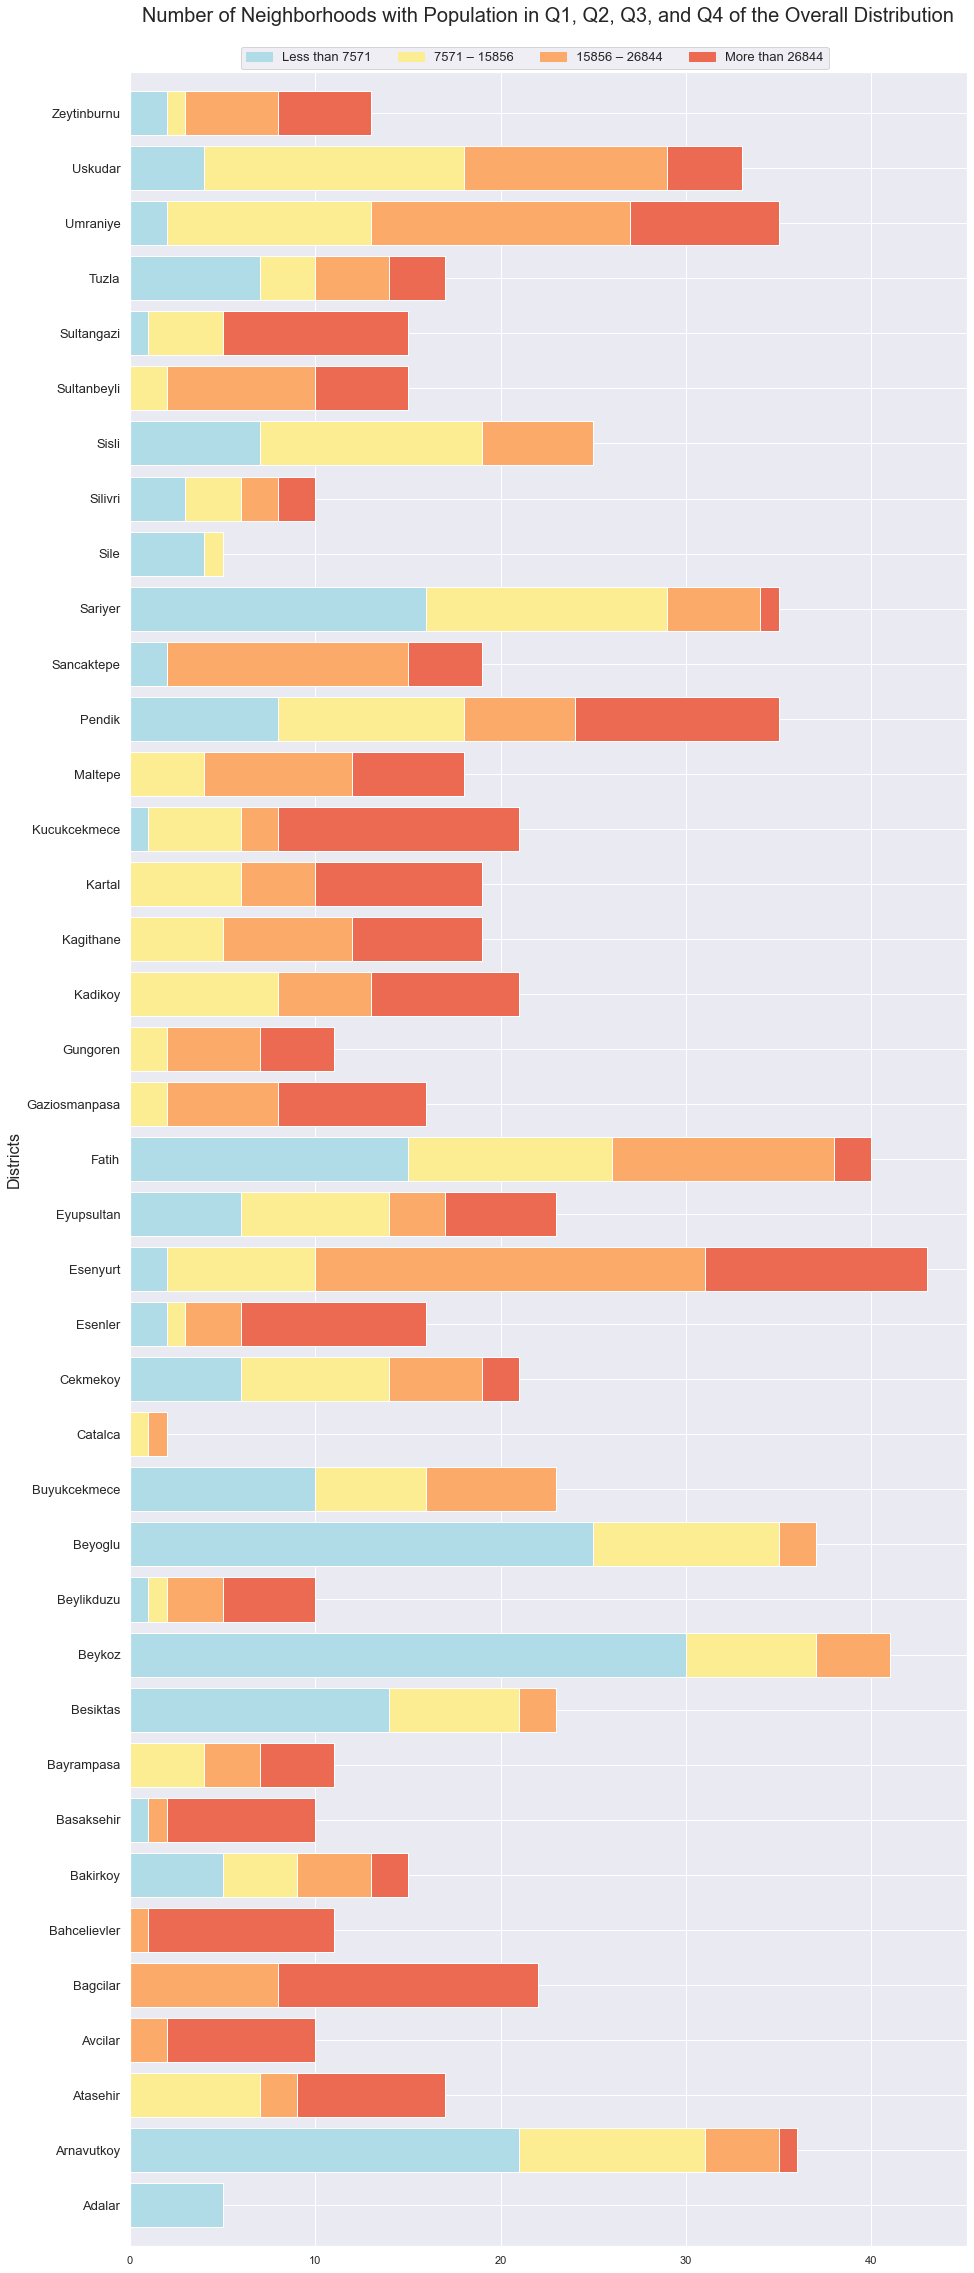

In [413]:
districts = socio_filtered['district'].unique()

fig,ax = plt.subplots()
fig.set_size_inches(15,40)

ax.barh(np.arange(len(districts)), bars_1, color="#B0DCE8", edgecolor=None)
patch1 = mpatches.Patch(color="#B0DCE8", label='Less than %i' %quartile_1)

ax.barh(np.arange(len(districts)), bars_2, left=bars_1, color="#FCEC92", edgecolor=None)
patch2 = mpatches.Patch(color="#FCEC92", label='%i – %i' %(quartile_1,quartile_2))

ax.barh(np.arange(len(districts)), bars_3, left=bars_3_left, color="#FBAA6A", edgecolor=None)
patch3 = mpatches.Patch(color="#FBAA6A", label='%i – %i' %(quartile_2,quartile_3))

ax.barh(np.arange(len(districts)), bars_4, left=bars_4_left, color="#EC6A52", edgecolor=None)
patch4 = mpatches.Patch(color="#EC6A52", label='More than %i' %quartile_3)

ax.set_yticks(np.arange(len(districts)))
ax.set_yticklabels([d.title() for d in districts], fontsize=FONT_SM)
ax.set_ylabel('Districts', fontsize=FONT_MED)

ax.legend(handles=[patch1,patch2,patch3,patch4], 
          ncol=4,
          loc='upper center', 
          bbox_to_anchor=(0.5, .891),
          bbox_transform=plt.gcf().transFigure,
          fontsize=FONT_SM)

plt.ylim([-.75,np.arange(len(districts)).size - .25])
plt.title('Number of Neighborhoods with Population in Q1, Q2, Q3, and Q4 of the Overall Distribution', 
          pad=50,
          fontsize=FONT_LG)
plt.show()

In [253]:
# Function that calculates rate of change from previous year to next
def rate_of_change(prev_yr, next_yr):
    return (next_yr - prev_yr) / prev_yr

In [254]:
# Creates population change features for the years that exist in our dataset

## Population Change for 1-Year Intervals
socio_filtered['pop change 15-16'] = rate_of_change(socio_filtered['2015 Toplam Nufus'],
                                                    socio_filtered['2016 Toplam Nufus'])

socio_filtered['pop change 16-17'] = rate_of_change(socio_filtered['2016 Toplam Nufus'],
                                                    socio_filtered['Total Population 2017'])

socio_filtered['pop change 17-18'] = rate_of_change(socio_filtered['Total Population 2017'],
                                                    socio_filtered['Total Population 2018'])

socio_filtered['pop change 18-19'] = rate_of_change(socio_filtered['Total Population 2018'],
                                                    socio_filtered['Total Population 2019'])

## Population Change for 2-Year Intervals
socio_filtered['pop change 15-17'] = rate_of_change(socio_filtered['2015 Toplam Nufus'],
                                                    socio_filtered['Total Population 2017'])

socio_filtered['pop change 17-19'] = rate_of_change(socio_filtered['Total Population 2017'],
                                                    socio_filtered['Total Population 2019'])

## Population Change for 4-Year Interval
socio_filtered['pop change 15-19'] = rate_of_change(socio_filtered['2015 Toplam Nufus'],
                                                    socio_filtered['Total Population 2019'])

In [94]:
# Creates subsets of the df with only population change features, for visualizations at the next step
pop_change = [col for col in socio_filtered.columns if 'pop change' in col]
pop_change_1_year = pop_change[0:4]
pop_change_2_year = pop_change[4:6]
pop_change_4_year = pop_change[-1]

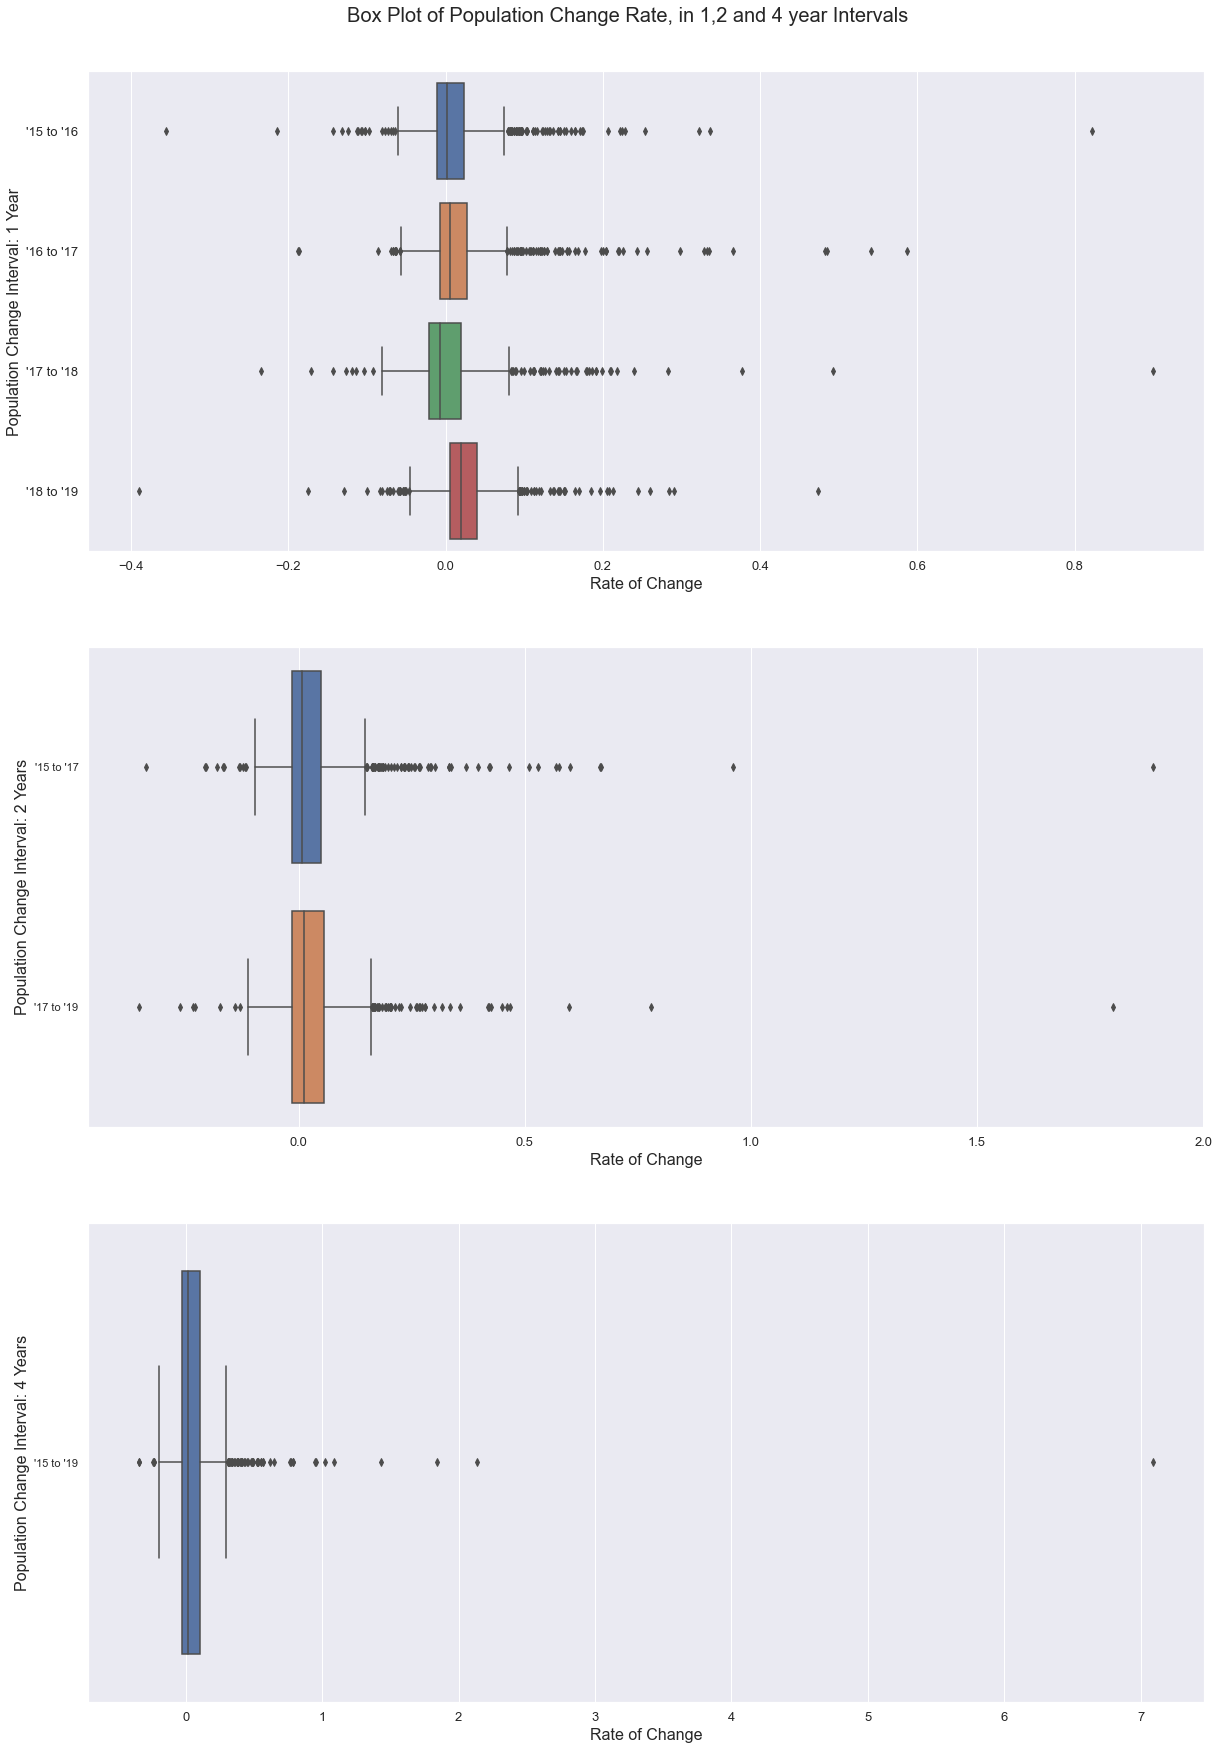

In [160]:
# Creates boxplots of Population Change features, to see their distributions over the intervals
fig, axes = plt.subplots(nrows=3, figsize=(20,30))

sns.boxplot(ax=axes[0], data=socio_filtered[pop_change_1_year], orient='h')
axes[0].set_ylabel('Population Change Interval: 1 Year',fontsize=FONT_MED)
axes[0].set_yticklabels(["'15 to '16","'16 to '17","'17 to '18","'18 to '19"], fontsize=FONT_SM)
axes[0].set_xlabel('Rate of Change',fontsize=FONT_MED)
plt.setp(axes[0].get_xticklabels(),fontsize=FONT_SM)

sns.boxplot(ax=axes[1], data=socio_filtered[pop_change_2_year], orient='h')
axes[1].set_ylabel('Population Change Interval: 2 Years',fontsize=FONT_MED)
axes[1].set_yticklabels(["'15 to '17","'17 to '19"])
axes[1].set_xlabel('Rate of Change',fontsize=FONT_MED)
plt.setp(axes[1].get_xticklabels(),fontsize=FONT_SM)

sns.boxplot(ax=axes[2], data=socio_filtered[pop_change_4_year], orient='h')
axes[2].set_ylabel('Population Change Interval: 4 Years',fontsize=FONT_MED)
axes[2].set_yticklabels(["'15 to '19"])
axes[2].set_xlabel('Rate of Change',fontsize=FONT_MED)
plt.setp(axes[2].get_xticklabels(),fontsize=FONT_SM)

plt.suptitle('Box Plot of Population Change Rate, in 1,2 and 4 year Intervals', y=.91, size=FONT_LG)
plt.subplots_adjust(hspace=.2)
plt.show()

In [255]:
# Drops total population features except the most recent one, since keeping them would result in multicollinearity
socio_filtered = socio_filtered.drop(columns=['2015 Toplam Nufus',
                                              '2016 Toplam Nufus',
                                              'Total Population 2017',
                                              'Total Population 2018'])

In [256]:
# Creates a feature for female population per male population
socio_filtered['women:men'] = socio_filtered['2016 Toplam Nufus (Kadin)'] / socio_filtered['2016 Toplam Nufus (Erkek)']

In [257]:
# Drops gender population features; they would likely be multicollinear with each other, and total population
socio_filtered = socio_filtered.drop(columns=['2016 Toplam Nufus (Kadin)', '2016 Toplam Nufus (Erkek)'])

In [258]:
# Creates rate of change feature for average age
socio_filtered['avg age change 15-16'] = rate_of_change(socio_filtered['Ortalama Yas 2015'],
                                                        socio_filtered['Ortalama Yas 2016'])

In [259]:
# Drops the older average age feature
socio_filtered = socio_filtered.drop(columns=['Ortalama Yas 2015'])

In [261]:
# Calculates population density
socio_filtered['population density per km2'] = socio_filtered['Total Population 2019'] /\
                                               socio_filtered['Yuzolcumu (km2)']

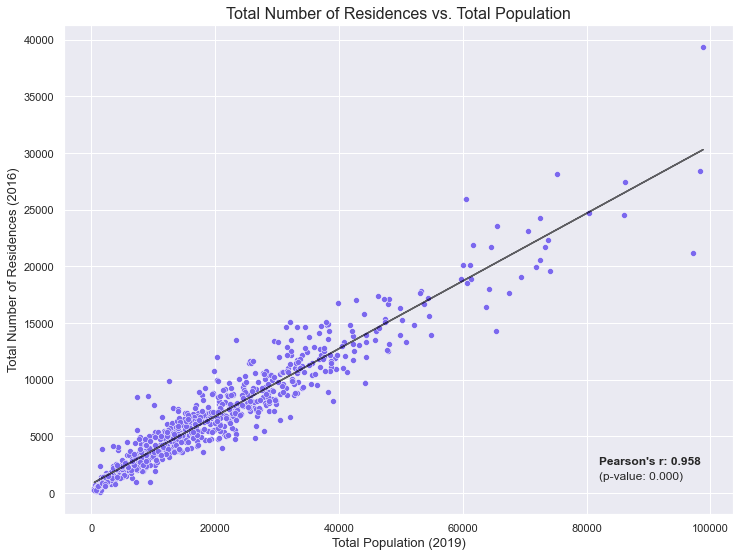

In [304]:
linear_relationship(socio_filtered, 'Total Population 2019', 'Toplam Konut Sayisi 2016',
                    'Total Number of Residences vs. Total Population', 
                    'Total Population (2019)', 'Total Number of Residences (2016)', 82000, 2500)

In [417]:
# 'Total Number of Residences' feature and 'Total Population' are highly correlated
# Hence, a new feature that reduces multicollinearity is engineered
socio_filtered['Residential/Work'] = socio_filtered['Toplam Konut Sayisi 2016'] /\
                                     socio_filtered['Ozel Isyeri Sayisi 2016']

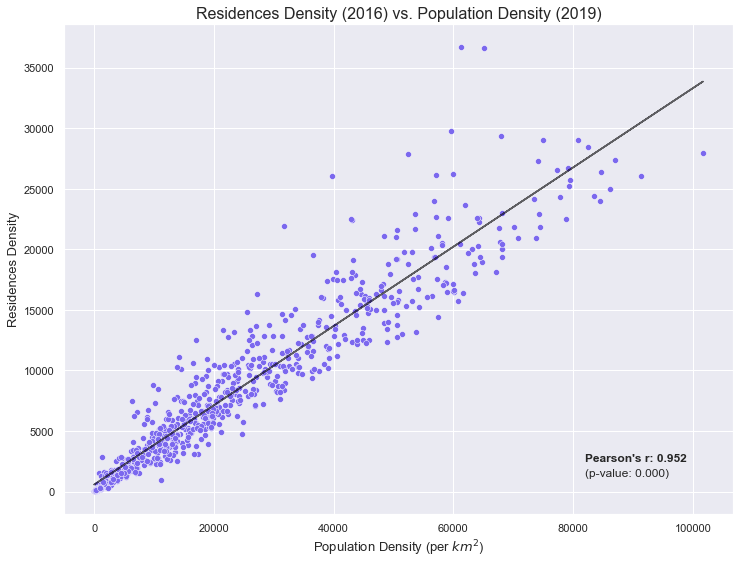

In [416]:
linear_relationship(socio_filtered, 'population density per km2', 'Residences Density',
                    'Residences Density (2016) vs. Population Density (2019)', 
                    'Population Density (per km)', 'Residences Density (2016)', 82000, 2500)

In [ ]:
linear_relationship(socio_filtered, 'Total Population 2019', 'Residences Density',
                    'Residences Density vs. Total Population', 
                    'Total Population (2019)', 'Residences Density (2016)', 82000, 2500)

In [62]:
# Drops 'total number of residences' and 'total land area' feature
socio_filtered = socio_filtered.drop(columns=['Toplam Konut Sayisi 2016','Yuzolcumu (km2)'])

In [63]:
# Three binary features (existence of cultural centers, movie theaters, and playhouses) exist in our dataset
# Creates an overall 'cultural' featur by summing the three
socio_filtered['cultural'] = socio_filtered['Kultur Sanat Merkezi Varligi'] + socio_filtered['Sinema Varligi'] + socio_filtered['Tiyatro Varligi']

In [64]:
# Combines those have 3 and 2 on 'cultural' column, as 3's are very few
socio_filtered['cultural'] = socio_filtered['cultural'].replace(3,2)

In [63]:
# Creates two features for high and medium number of cultural & arts centers
# Does not create a third feature for low, to avoid multicollinearity
socio_filtered['cultural high'] = 0
socio_filtered['cultural med'] = 0

for i in range(len(socio_filtered)):
    if socio_filtered.loc[i,'cultural'] == 2:
        socio_filtered.at[i,'cultural high'] = 1
    elif socio_filtered.loc[i,'cultural'] == 1:
        socio_filtered.at[i,'cultural med'] = 1

In [64]:
# Drops columns that are no longer needed
socio_filtered = socio_filtered.drop(columns=['cultural', 'Kultur Sanat Merkezi Varligi', 'Sinema Varligi', 'Tiyatro Varligi'])

In [65]:
# Checks the unique values in the 'number of subway stations' feature
socio_filtered['Metro Durak Sayisi'].unique()

array([0., 1., 2., 3., 5., 4.])

In [66]:
# Since only a few neighborhoods have any stations, the feature is turned into a binary one (station exists or not)
socio_filtered['Metro Durak Sayisi'] = socio_filtered['Metro Durak Sayisi'].replace({5:1, 4:1, 3:1, 2:1})

In [67]:
# Checks the unique values in the 'number of shopping malls' feature
socio_filtered['AVM Sayisi 2017'].unique()

array([0., 1., 3., 2., 4.])

In [68]:
# Similarly, number of shopping malls feature is turned into a binary one
socio_filtered['AVM Sayisi 2017'] = socio_filtered['AVM Sayisi 2017'].replace({4:1, 3:1, 2:1})

In [69]:
# Once again, the feature 'number of bazaar places' is 0 for most observations in our dataset
socio_filtered['Pazar Yeri Sayi 2017'].value_counts()

0.0     421
1.0     306
2.0      47
3.0      10
5.0       5
4.0       4
6.0       2
8.0       1
11.0      1
9.0       1
Name: Pazar Yeri Sayi 2017, dtype: int64

In [70]:
# Turns the 'number of bazaar places' feature into binary
not_zero = [int(i) for i in socio_filtered['Pazar Yeri Sayi 2017'].unique() if i != 0 and i != 1]

replace_dict = dict()
for k in not_zero:
    replace_dict[k] = 1

socio_filtered['Pazar Yeri Sayi 2017'] = socio_filtered['Pazar Yeri Sayi 2017'].replace(replace_dict)

In [71]:
# Real estate measure is created, average of Price of Houses for Sale and Houses for Rent features both on a scale (1-10)
socio_filtered['real estate'] = (socio_filtered['Satilik Konut Bedeli (m2 TL) 2017'] + socio_filtered['Kiralik Konut Bedeli (m2 TL) 2017']) / 2

In [72]:
# Divides the real estate into three categories, and keeps two of them as features
socio_filtered['real estate low'] = 0
socio_filtered['real estate high'] = 0

for i in range(len(socio_filtered)):
    if socio_filtered.loc[i,'real estate'] >= 6.5:
        socio_filtered.at[i,'real estate high'] = 1
    # Does not include 0s since 0 has been assigned to neighborhoods without any houses for sale/rent
    elif 4 > socio_filtered.loc[i,'real estate'] > 0:
        socio_filtered.at[i,'real estate low'] = 1

In [73]:
# Drops the features we no longer need
socio_filtered = socio_filtered.drop(columns=['real estate','Kiralik Konut Bedeli (m2 TL) 2017','Satilik Konut Bedeli (m2 TL) 2017'])

In [74]:
# Drops old (reset) index columns
socio_filtered = socio_filtered.drop(columns=['index'])

In [75]:
# Drops district and nbhd name columns, and sets nbhd_id as index, since nbhd_id can uniquely identify each neighborhood
socio_filtered = socio_filtered.drop(columns=['district','nbhd']).set_index('nbhd_id')

print(socio_filtered.shape)
socio_filtered.head()

(798, 37)


,Z Kusagi (0-19 yas) 2016,Y Kusagi (20-39 yas) 2016,X Kusagi (40-54 yas) 2016,Ortalama Yas 2016,Hic Evlenmeyenler 2016,Evli Olanlar 2016,Bosananlar 2016,Hane Halki Ortalama Buyuklugu 2016,Ozel Isyeri Sayisi 2016,Ilkokul Mezunu 2016,...,pop change 15-17,pop change 17-19,women:men,avg age change 15-16,population density per km2,Residences Density,cultural high,cultural med,real estate low,real estate high
nbhd_id,,,,,,,,,,,,,,,,,,,,,
101,22.5,23.98,11.95,46.56,25.65,54.71,11.48,2.29,81.0,19.65,...,0.013231,-0.019244,1.0431,0.0128345,880.864198,1498.148148,0,1,0,0
102,21.19,30.45,15.28,42.25,32.54,50.34,8.99,2.66,181.0,20.09,...,-0.131034,0.022848,0.922723,0.158169,1629.501916,1472.796935,0,0,0,1
103,21.26,22.99,10.6,48.04,24.73,62.13,6.8,2.35,125.0,24.16,...,-0.123107,-0.020613,0.914573,0.00523122,1292.647059,2833.823529,0,0,1,0
104,22.72,28.54,19.4,40.47,28.2,55.46,9.56,2.7,287.0,20.52,...,-0.001607,-0.004369,0.948315,0.00696691,1732.000000,1644.400000,0,0,0,1
105,23.64,26.28,19.32,41.36,27.55,56.19,9.91,2.65,430.0,21.42,...,0.050350,0.101587,0.973548,0.00681597,1074.303406,1278.637771,0,0,0,1


In [76]:
socio_filtered.columns

Index(['Z Kusagi (0-19 yas) 2016 ', 'Y Kusagi (20-39 yas) 2016',
       'X Kusagi (40-54 yas) 2016', 'Ortalama Yas 2016',
       'Hic Evlenmeyenler 2016', 'Evli Olanlar 2016', 'Bosananlar 2016',
       'Hane Halki Ortalama Buyuklugu 2016', 'Ozel Isyeri Sayisi 2016',
       'Ilkokul Mezunu 2016', 'Universite Mezunu 2016',
       'Okuryazar Orani - Kadin 2016', 'Ortalama Egitim Suresi 2016',
       'ASM Varligi', 'Ozel Hastane Varligi',
       'Dogalgaz Kullanici Sayisi/Nufus 2017', 'Su Ariza Suresi (Saat) 2016',
       'Metro Durak Sayisi', 'Market Yogunluk Endeksi 2017', 'AVM Sayisi 2017',
       'Pazar Yeri Sayi 2017', 'Total Population 2019', 'pop change 15-16',
       'pop change 16-17', 'pop change 17-18', 'pop change 18-19',
       'pop change 15-19', 'pop change 15-17', 'pop change 17-19', 'women:men',
       'avg age change 15-16', 'population density per km2',
       'Residences Density', 'cultural high', 'cultural med',
       'real estate low', 'real estate high'],
      dtyp

In [77]:
socio_filtered = socio_filtered.rename(columns={'Z Kusagi (0-19 yas) 2016 ':'Gen Z Percent',
                                                'Y Kusagi (20-39 yas) 2016':'Gen Y Percent',
                                                'X Kusagi (40-54 yas) 2016':'Gen X Percent',
                                                'Ortalama Yas 2016':'Average Age',
                                                'Hic Evlenmeyenler 2016':'Never Married',
                                                'Evli Olanlar 2016':'Married',
                                                'Bosananlar 2016':'Divorced',
                                                'Hane Halki Ortalama Buyuklugu 2016':'Avg Household Size',
                                                'Ozel Isyeri Sayisi 2016':'Num Priv Workplaces',
                                                'Ilkokul Mezunu 2016':'Educ Primary School',
                                                'Universite Mezunu 2016':'Educ College',
                                                'Okuryazar Orani - Kadin 2016':'Percent Literate Women',
                                                'Ortalama Egitim Suresi 2016':'Avg Length Educ',
                                                'ASM Varligi':'State Health Center',
                                                'Ozel Hastane Varligi':'Private Hospital',
                                                'Dogalgaz Kullanici Sayisi/Nufus 2017':'Gas for Heating Rate',
                                                'Su Ariza Suresi (Saat) 2016':'Hours of Water Outage',
                                                'Metro Durak Sayisi':'Subway Stations',
                                                'Market Yogunluk Endeksi 2017':'Supermarket Dens Index',
                                                'AVM Sayisi 2017':'Shopping Malls',
                                                'Pazar Yeri Sayi 2017':'Bazaar Places',
                                                'pop change 15-16':'Population Change 15-16',
                                                'pop change 16-17':'Population Change 16-17',
                                                'pop change 17-18':'Population Change 17-18',
                                                'pop change 18-19':'Population Change 18-19',
                                                'pop change 15-17':'Population Change 15-17',
                                                'pop change 17-19':'Population Change 17-19',
                                                'pop change 15-19':'Population Change 15-19',
                                                'women:men':'Population Women / Men',
                                                'avg age change 15-16':'Avg Age Change',
                                                'population density per km2':'Population Density',
                                                'cultural high':'Cultural High',
                                                'cultural med':'Cultural Medium',
                                                'real estate low':'Real Estate Low',
                                                'real estate high':'Real Estate High'})

In [78]:
socio_filtered.columns

Index(['Gen Z Percent', 'Gen Y Percent', 'Gen X Percent', 'Average Age',
       'Never Married', 'Married', 'Divorced', 'Avg Household Size',
       'Num Priv Workplaces', 'Educ Primary School', 'Educ College',
       'Percent Literate Women', 'Avg Length Educ', 'State Health Center',
       'Private Hospital', 'Gas for Heating Rate', 'Hours of Water Outage',
       'Subway Stations', 'Supermarket Dens Index', 'Shopping Malls',
       'Bazaar Places', 'Total Population 2019', 'Population Change 15-16',
       'Population Change 16-17', 'Population Change 17-18',
       'Population Change 18-19', 'Population Change 15-19',
       'Population Change 15-17', 'Population Change 17-19',
       'Population Women / Men', 'Avg Age Change', 'Population Density',
       'Residences Density', 'Cultural High', 'Cultural Medium',
       'Real Estate Low', 'Real Estate High'],
      dtype='object')

In [79]:
features = socio_filtered.sort_index().to_numpy()
print(features.shape)
features

(798, 37)


array([[22.5, 23.98, 11.95, ..., 1, 0, 0],
       [21.19, 30.45, 15.28, ..., 0, 0, 1],
       [21.26, 22.99, 10.6, ..., 0, 1, 0],
       ...,
       [19.08, 36.15, 30.86, ..., 0, 0, 0],
       [20.35, 34.89, 29.5, ..., 0, 0, 0],
       [18.75, 35.81, 32.21, ..., 0, 0, 0]], dtype=object)

## 4) Preparing the Targets for Feature Selection & Analysis

Using SQL queries, we created several political targets that are going to be used for forecasting. Those targest are in 7 different csv files, one for each election. Some of the targets are more general, in the sense that they can give a sense on the general political climate, while some are more suited to make conclusions regarding specific election. 

Due to the recent regime change, Turkey is now being governed by a presidential system and the candidate that reaches %50 + 1 vote is elected. Hence, the most comprehensive targets in this analysis are those that divide the total government block vote into total opposition block vote. Closer those ratios to 1, the more neck-and-neck the elections are; the greater it is, government block has more support, and vice-versa.

At this step, all the csv's are imported and filtered so that only the remaining neighborhoods in socioeconomic dataset are included in the analysis. For feature selection, the four main targets (govt block:opposition block) are determined from 4 elections, 2019 re-run, 2019 local, 2018 presidential and 2017 referendum. 2018 MP election is not included, since it was carried out at the same time as presidential and one will suffice for our purposes. Both of 2015 elections are also excluded, as the government and opposition blocks were not as prononunced back then.

In [80]:
# Imports SQL output csv files
reelect19 = pd.read_csv('/Users/ercansen/Desktop/apps/istanbul/sql outputs/reelect_19.csv')
local19 = pd.read_csv('/Users/ercansen/Desktop/apps/istanbul/sql outputs/local_19.csv')
mp18 = pd.read_csv('/Users/ercansen/Desktop/apps/istanbul/sql outputs/mp_18.csv')
pres18 = pd.read_csv('/Users/ercansen/Desktop/apps/istanbul/sql outputs/pres_18.csv')
ref17 = pd.read_csv('/Users/ercansen/Desktop/apps/istanbul/sql outputs/ref_17.csv')
gen_nov15 = pd.read_csv('/Users/ercansen/Desktop/apps/istanbul/sql outputs/gen_nov_15.csv')
gen_jun15 = pd.read_csv('/Users/ercansen/Desktop/apps/istanbul/sql outputs/gen_jun_15.csv')

In [81]:
# Re-indexes so that only the same subset of neighborhoods in filtered socioeconomic data remains
reelect19 = reelect19.set_index('nbhd_id').reindex(socio_filtered.index)
local19 = local19.set_index('nbhd_id').reindex(socio_filtered.index)
mp18 = mp18.set_index('nbhd_id').reindex(socio_filtered.index)
pres18 = pres18.set_index('nbhd_id').reindex(socio_filtered.index)
ref17 = ref17.set_index('nbhd_id').reindex(socio_filtered.index)
gen_nov15 = gen_nov15.set_index('nbhd_id').reindex(socio_filtered.index)
gen_jun15 = gen_jun15.set_index('nbhd_id').reindex(socio_filtered.index)

In [82]:
# Prints the column names for political features in 2019 mayoral election re-run csv
reelect19.columns

Index(['district', 'neighborhood', 'registered', 'voted', 'valid', 'akp',
       'chp', 'sp', 'voted_march', 'akp_march', 'chp_march', 'turnout',
       'valid_p', 'akp_p', 'chp_p', 'sp_p', 'chp_sp', 'chp_sp_p', 'chp_sp_r',
       'chp_sp30', 'chp_sp30_p', 'chp_sp30_r', 'chp_sp40', 'chp_sp40_p',
       'chp_sp40_r', 'akp_sp50', 'akp_sp50_p', 'akp_sp50_r', 'akp_sp55',
       'akp_sp55_p', 'akp_sp55_r', 'cum_mil_nosp', 'cum_mil_low', 'cum_mil_hi',
       'turnout_dif', 'akp_dif', 'chp_dif', 'turnout_rate_ch', 'akp_rate_ch',
       'chp_rate_ch', 'akp_rc_turnout'],
      dtype='object')

In [83]:
# Creates the first gov:opp ratio target
gov_opp_19_6 = reelect19['cum_mil_hi'].sort_index().to_numpy()

In [84]:
# Prints the column names for political features in 2019 local election csv
local19.columns

Index(['district', 'neighborhood', 'registered', 'voted', 'valid', 'akp',
       'chp', 'sp', 'turnout', 'valid_p', 'akp_p', 'chp_p', 'sp_p', 'chp_sp',
       'chp_sp_p', 'chp_sp_r', 'chp_sp30', 'chp_sp30_p', 'chp_sp30_r',
       'chp_sp40', 'chp_sp40_p', 'chp_sp40_r', 'akp_sp50', 'akp_sp50_p',
       'akp_sp50_r', 'akp_sp55', 'akp_sp55_p', 'akp_sp55_r', 'cum_mil_nosp',
       'cum_mil_low', 'cum_mil_hi'],
      dtype='object')

In [85]:
# Creates the second gov:opp ratio target
gov_opp_19_3 = local19['cum_mil_hi'].sort_index().to_numpy()

In [86]:
# Prints the column names for political features in 2018 presidential election csv
pres18.columns

Index(['district', 'neighborhood', 'registered', 'voted', 'valid', 'rte',
       'ince', 'aksener', 'selo', 'karamolla', 'cumhur_tot_mp', 'turnout',
       'valid_p', 'rte_p', 'ince_p', 'aksener_p', 'selo_p', 'karamolla_p',
       'rte_r', 'ince_r', 'aksener_r', 'selo_r', 'karamolla_r', 'millet_off',
       'millet_off_p', 'millet_off_r', 'millet_hdp_nosp', 'millet_hdp_nosp_p',
       'millet_hdp_nosp_r', 'millet_hdp_sp30', 'millet_hdp_sp30_p',
       'millet_hdp_sp30_r', 'millet_hdp_sp40', 'millet_hdp_sp40_p',
       'millet_hdp_sp40_r', 'cumhur_sp50', 'cumhur_sp50_p', 'cumhur_sp50_r',
       'cumhur_sp55', 'cumhur_sp55_p', 'cumhur_sp55_r', 'cum_mil_nosp',
       'cum_mil_low', 'cum_mil_hi', 'rte_change', 'rte_change_cum',
       'rte_change_reg'],
      dtype='object')

In [87]:
# Creates the third gov:opp ratio target
gov_opp_18_6 = pres18['cum_mil_hi'].sort_index().to_numpy()

In [88]:
# Prints the column names for political features in 2017 referendum
ref17.columns

Index(['district', 'neighborhood', 'registered', 'voted', 'valid', 'yes',
       'nop', 'turnout', 'valid_p', 'yes_p', 'nop_p', 'yes_r', 'nop_r',
       'yes_no'],
      dtype='object')

In [89]:
# Creates the fourth gov:opp ratio target
gov_opp_17_4 = ref17['yes_no'].sort_index().to_numpy()

## 5) Feature Selection

Feature selection is a crucial step, especially for our problem. Since our features are socioeconomic data, many of them are expected to have high correlation. Some, like "average length of education" and "percent graduated from college", are expected to have it since they measure a similar societal parameter. Yet, some like "avg length of education" and "housing prices: high" are also highly correlated, not because they measure the same parameters, but because there are certain common factors (in this case, for instance, income level) that affect both features. We expect that those similar to the former example would cause a serious issue of multicollinearity, vastly decreasing the accuracy of our predictions. Those like the latter should also be examined carefully and some features might have to be removed in order to avoid getting an overfitting model. For multicollinearity detection and feature selection, we are going to utilize measures and tools like VIF, correlation matrix and SelectKBest.

In [90]:
mc_initial = [(['Gen Z Percent', 'Gen Y Percent', 'Gen X Percent'],['Average Age','Avg Age Change']),
              (['Population Change 15-16','Population Change 16-17','Population Change 17-18','Population Change 18-19'],
               ['Population Change 15-17','Population Change 17-19'],
               ['Population Change 15-19']),
              (['Population Density'],['Residences Density'],['Avg Household Size']),
              (['Educ Primary School','Educ College'],['Avg Length Educ'],['Percent Literate Women'])]

In [91]:
def train_filter_features(tup, data, target):
    temp_list = list()
    
    for i in range(len(tup)):
        other_inds = [j for j in range(len(tup)) if j != i]
        cols_to_drop = [tup[k] for k in other_inds]
        drop = list()
        for li in cols_to_drop:
            drop += li
        data_filt = data.drop(columns=drop)
        
        X_tr, X_te, y_tr, y_te = train_test_split(data_filt.to_numpy(), target, test_size=0.2, random_state=91)
        model = RandomForestRegressor(n_estimators=250, random_state=91, n_jobs=-1)
        model.fit(X_tr, y_tr)
        
        temp_list.append((tup[i],model.score(X_te,y_te)))
        
    return temp_list
#max(temp_list, key = lambda x: x[1])[0], max(temp_list, key = lambda x: x[1])[1]

In [92]:
for tup in mc_initial:
    print(train_filter_features(tup, socio_filtered, gov_opp_17_4))

[(['Gen Z Percent', 'Gen Y Percent', 'Gen X Percent'], 0.031238260488130724), (['Average Age', 'Avg Age Change'], 0.017246418659513263)]
[(['Population Change 15-16', 'Population Change 16-17', 'Population Change 17-18', 'Population Change 18-19'], 0.06050312516064693), (['Population Change 15-17', 'Population Change 17-19'], 0.05138796124377243), (['Population Change 15-19'], 0.09217685068215375)]
[(['Population Density'], 0.003477765127877453), (['Residences Density'], 0.004363727294572128), (['Avg Household Size'], -0.30346674257119344)]
[(['Educ Primary School', 'Educ College'], 0.11925146860709757), (['Avg Length Educ'], 0.03155382839886167), (['Percent Literate Women'], 0.038306627485116596)]


Among the combinations that were tried, [Gen Z, Gen Y, Gen X], Population Change 15-19, Residences Density, [Educ Primary School, Educ College] gave the best results, so only they will be kept, as opposed to the others that will not be considered.

In [93]:
socio_filtered.shape

(798, 37)

In [95]:
socio_fin = socio_filtered.drop(columns=['Average Age', 'Avg Age Change', 
                                         'Population Change 15-16', 'Population Change 16-17', 'Population Change 17-18',
                                         'Population Change 18-19', 'Population Change 15-17', 'Population Change 17-19',
                                         'Population Density', 'Avg Household Size', 'Avg Length Educ', 'Percent Literate Women'])

In [96]:
socio_fin.shape

(798, 25)

In [97]:
socio_fin.columns

Index(['Gen Z Percent', 'Gen Y Percent', 'Gen X Percent', 'Never Married',
       'Married', 'Divorced', 'Num Priv Workplaces', 'Educ Primary School',
       'Educ College', 'State Health Center', 'Private Hospital',
       'Gas for Heating Rate', 'Hours of Water Outage', 'Subway Stations',
       'Supermarket Dens Index', 'Shopping Malls', 'Bazaar Places',
       'Total Population 2019', 'Population Change 15-19',
       'Population Women / Men', 'Residences Density', 'Cultural High',
       'Cultural Medium', 'Real Estate Low', 'Real Estate High'],
      dtype='object')

In [98]:
# Function that calculates the VIF matrix of features
def vif_matrix(X):
    vif_mat = pd.DataFrame()
    vif_mat['features'] = X.columns
    vif_mat['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_mat = vif_mat.set_index('features')
    
    return vif_mat

In [106]:
# Creates the VIF matrix for our features dataframe
vif_mat = vif_matrix(socio_fin.astype(float))

# Initializes dictionary, with keys being the features with high VIF, and values are empty lists
high_vif = {f:list() for f in vif_mat.index if vif_mat.loc[f,'VIF'] >= 5}

In [107]:
# Prints out the VIF matrix
vif_mat

,VIF
features,
Gen Z Percent,204.915265
Gen Y Percent,246.365305
Gen X Percent,152.808811
Never Married,207.493609
Married,928.423222
Divorced,22.999173
Num Priv Workplaces,2.959053
Educ Primary School,121.699069
Educ College,53.142549


In [108]:
# Prints out the dictionary
high_vif

{'Gen Z Percent': [],
 'Gen Y Percent': [],
 'Gen X Percent': [],
 'Never Married': [],
 'Married': [],
 'Divorced': [],
 'Educ Primary School': [],
 'Educ College': [],
 'Gas for Heating Rate': [],
 'Total Population 2019': [],
 'Population Women / Men': []}

In [109]:
# Creates the correlation matrix for features
corr_mat = socio_fin.astype(float).corr()

# Populates the dictionary with highly correlated features
for i in range(len(corr_mat)):
    for j in range(len(corr_mat)):
        if np.abs(corr_mat.iloc[i,j]) >= 0.6 and i != j:
            try:
                high_vif[corr_mat.index[i]].append(corr_mat.columns[j])
            except:
                high_vif[corr_mat.columns[j]].append(corr_mat.index[i])

In [110]:
# Prints out the populated dictionary
high_vif

{'Gen Z Percent': [],
 'Gen Y Percent': ['Never Married'],
 'Gen X Percent': ['Married', 'Divorced', 'Educ College'],
 'Never Married': ['Gen Y Percent', 'Married'],
 'Married': ['Gen X Percent', 'Never Married', 'Divorced'],
 'Divorced': ['Gen X Percent',
  'Married',
  'Educ Primary School',
  'Educ College'],
 'Educ Primary School': ['Divorced', 'Educ College'],
 'Educ College': ['Gen X Percent',
  'Divorced',
  'Educ Primary School',
  'Real Estate High',
  'Real Estate High'],
 'Gas for Heating Rate': [],
 'Total Population 2019': [],
 'Population Women / Men': []}

In [111]:
# Some of the lists (values of dict) are empty, corresponding keys are removed from the dictionary
high_vif = {k:v for k,v in high_vif.items() if len(v)>0}

In [112]:
# Prints the populated dictionary once again
high_vif

{'Gen Y Percent': ['Never Married'],
 'Gen X Percent': ['Married', 'Divorced', 'Educ College'],
 'Never Married': ['Gen Y Percent', 'Married'],
 'Married': ['Gen X Percent', 'Never Married', 'Divorced'],
 'Divorced': ['Gen X Percent',
  'Married',
  'Educ Primary School',
  'Educ College'],
 'Educ Primary School': ['Divorced', 'Educ College'],
 'Educ College': ['Gen X Percent',
  'Divorced',
  'Educ Primary School',
  'Real Estate High',
  'Real Estate High']}

In [113]:
# Creates a copy of the dictionary that was created previously
sub_df_vifs = high_vif.copy()

# Checks if removing the key or values (list of highly correlated columns) result in better findings in terms of VIF 
for k,v in high_vif.items():
    temp_df_key = socio_filtered.drop(columns=k).astype(float)
    temp_df_val = socio_filtered.drop(columns=v).astype(float)
    
    vif_key = vif_matrix(temp_df_key)
    vif_val = vif_matrix(temp_df_val)
    
    all_cols = v.copy()
    all_cols.append(k)
    
    sub_df_vifs[k] = (vif_mat.loc[all_cols],vif_key.loc[v],vif_val.loc[[k]])

In [114]:
# Prints out the findings
for k,v in sub_df_vifs.items():
    print(k,'\n')
    print('VIF for full set of features:')
    print(v[0],'\n')
    print('VIF with key removed:')
    print(v[1],'\n')
    print('VIF with values removed:')
    print(v[2],'\n')
    print('-------------------------- o --------------------------')

Gen Y Percent 

VIF for full set of features:
                      VIF
features                 
Never Married  207.493609
Gen Y Percent  246.365305 

VIF with key removed:
                      VIF
features                 
Never Married  421.312953 

VIF with values removed:
                      VIF
features                 
Gen Y Percent  334.226919 

-------------------------- o --------------------------
Gen X Percent 

VIF for full set of features:
                      VIF
features                 
Married        928.423222
Divorced        22.999173
Educ College    53.142549
Gen X Percent  152.808811 

VIF with key removed:
                      VIF
features                 
Married       1856.285250
Divorced        48.749631
Educ College   174.975469 

VIF with values removed:
                      VIF
features                 
Gen X Percent  418.599734 

-------------------------- o --------------------------
Never Married 

VIF for full set of features:
                    

In [144]:
# Some columns are picked out of the analysis, as they resulted in tremendously high multicollinearity
socio_fin = socio_fin.drop(columns=['Married','Gen X Percent']).astype(float).sort_index()

In [145]:
socio_fin

,Gen Z Percent,Gen Y Percent,Never Married,Divorced,Num Priv Workplaces,Educ Primary School,Educ College,State Health Center,Private Hospital,Gas for Heating Rate,...,Shopping Malls,Bazaar Places,Total Population 2019,Population Change 15-19,Population Women / Men,Residences Density,Cultural High,Cultural Medium,Real Estate Low,Real Estate High
nbhd_id,,,,,,,,,,,,,,,,,,,,,
101,22.50,23.98,25.65,11.48,81.0,19.65,22.071051,1.0,0.0,0.616737,...,0.0,1.0,1427.0,-0.006267,1.043103,1498.148148,0.0,1.0,0.0,0.0
102,21.19,30.45,32.54,8.99,181.0,20.09,22.844950,1.0,0.0,0.536332,...,0.0,1.0,4253.0,-0.111181,0.922723,1472.796935,0.0,0.0,0.0,1.0
103,21.26,22.99,24.73,6.80,125.0,24.16,18.891967,1.0,0.0,0.465617,...,0.0,1.0,1758.0,-0.141182,0.914573,2833.823529,0.0,0.0,1.0,0.0
104,22.72,28.54,28.20,9.56,287.0,20.52,20.090749,0.0,0.0,0.454441,...,0.0,0.0,4330.0,-0.005969,0.948315,1644.400000,0.0,0.0,0.0,1.0
105,23.64,26.28,27.55,9.91,430.0,21.42,21.636168,1.0,0.0,0.522393,...,0.0,1.0,3470.0,0.157052,0.973548,1278.637771,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,21.27,34.19,29.95,5.76,2062.0,26.69,13.309855,1.0,0.0,0.304375,...,0.0,1.0,37552.0,-0.016345,0.999092,19362.121212,0.0,0.0,0.0,0.0
3910,20.07,35.40,31.61,4.13,3208.0,29.59,10.204818,1.0,0.0,0.299632,...,0.0,1.0,37469.0,-0.011972,0.983924,19725.000000,0.0,0.0,0.0,0.0
3911,19.08,36.15,33.18,4.24,1877.0,30.22,7.775950,1.0,0.0,0.264492,...,0.0,0.0,27275.0,-0.030636,0.970516,20440.000000,0.0,0.0,0.0,0.0


In [146]:
socio_fin.shape

(798, 23)

In [147]:
# VIF matrix is calculated once again
# There are still very high VIF values, which shows that we need to do more work on selecting the features
#  but the VIF values that are as high as thousands or even more no longer exist in the matrix
vif_matrix(socio_fin)

,VIF
features,
Gen Z Percent,100.730546
Gen Y Percent,132.227533
Never Married,73.988914
Divorced,15.998036
Num Priv Workplaces,2.916390
Educ Primary School,55.990896
Educ College,33.554455
State Health Center,4.289290
Private Hospital,1.404823


In [149]:
# Generates the correlation matrix for the new subset of features
corr_mat = socio_fin.corr()
correlated = list()

# Prints the highly correlated features and their level of correlation, adds the features to the list
for i in range(len(corr_mat)):
    for j in range(i):
        if corr_mat.iloc[i,j] >= .5:
            print(corr_mat.index[i],'and',corr_mat.columns[j],':',"%.3f"%corr_mat.iloc[i,j])
            correlated.append((corr_mat.index[i],corr_mat.columns[j]))

Never Married and Gen Y Percent : 0.644
Divorced and Gen Z Percent : 0.564
Educ College and Gen Z Percent : 0.553
Educ College and Divorced : 0.691
Total Population 2019 and Supermarket Dens Index : 0.592
Real Estate High and Divorced : 0.546
Real Estate High and Educ College : 0.627


In [150]:
# Prints the list
correlated

[('Never Married', 'Gen Y Percent'),
 ('Divorced', 'Gen Z Percent'),
 ('Educ College', 'Gen Z Percent'),
 ('Educ College', 'Divorced'),
 ('Total Population 2019', 'Supermarket Dens Index'),
 ('Real Estate High', 'Divorced'),
 ('Real Estate High', 'Educ College')]

In [151]:
# Trains the model holding off one of the correlated features at a time, and compares the performances
results = list()

for cor in correlated:
    temp1 = socio_fin.drop(columns=cor[0]).to_numpy()
    temp2 = socio_fin.drop(columns=cor[1]).to_numpy()
    
    X_tr1, X_te1, y_tr1, y_te1 = train_test_split(temp1, gov_opp_17_4)
    X_tr2, X_te2, y_tr2, y_te2 = train_test_split(temp2, gov_opp_17_4)
    
    rf1 = RandomForestRegressor(n_estimators=200, random_state=91)
    rf2 = RandomForestRegressor(n_estimators=200, random_state=91)
    
    rf1.fit(X_tr1, y_tr1)
    rf2.fit(X_tr2, y_tr2)
    
    results.append([('Removed '+cor[0],rf1.score(X_te1,y_te1)),('Removed '+cor[1],rf2.score(X_te2,y_te2))])

In [152]:
results

[[('Removed Never Married', 0.5822038125425982),
  ('Removed Gen Y Percent', 0.16692662568225736)],
 [('Removed Divorced', 0.4529019905606211),
  ('Removed Gen Z Percent', 0.3981341359841887)],
 [('Removed Educ College', 0.4499103871890918),
  ('Removed Gen Z Percent', 0.08045042126376589)],
 [('Removed Educ College', 0.1693355052637059),
  ('Removed Divorced', 0.4963699271963961)],
 [('Removed Total Population 2019', 0.4997839630318268),
  ('Removed Supermarket Dens Index', 0.1694149393854706)],
 [('Removed Real Estate High', 0.19312590112489292),
  ('Removed Divorced', 0.1969739535221383)],
 [('Removed Real Estate High', 0.17270388320385777),
  ('Removed Educ College', 0.41096409019060953)]]

In [153]:
socio_fin = socio_fin.drop(columns=['Never Married', 'Divorced','Total Population 2019'])

In [154]:
vif_mat = vif_matrix(socio_fin)

In [155]:
vif_mat

,VIF
features,
Gen Z Percent,88.960254
Gen Y Percent,36.224688
Num Priv Workplaces,2.751856
Educ Primary School,51.682840
Educ College,30.385553
State Health Center,4.090854
Private Hospital,1.399540
Gas for Heating Rate,13.294755
Hours of Water Outage,3.024803


In [217]:
socio_fin = socio_fin.drop(columns=['Population Women / Men','Educ Primary School','Gen Z Percent','Educ College'])

In [218]:
socio_fin.shape

(798, 16)

In [219]:
vif_fin = vif_matrix(socio_fin)
vif_fin

,VIF
features,
Gen Y Percent,14.145156
Num Priv Workplaces,2.662287
State Health Center,4.027625
Private Hospital,1.382999
Gas for Heating Rate,9.195362
Hours of Water Outage,2.624991
Subway Stations,1.383920
Supermarket Dens Index,3.039838
Shopping Malls,1.482386


In [220]:
features = socio_fin.to_numpy()

In [221]:
from sklearn.feature_selection import SelectKBest, f_regression

In [222]:
skb1 = SelectKBest(f_regression, k='all').fit(features, gov_opp_17_4)

In [223]:
skb_scores1 = dict(zip(socio_fin.columns,skb1.scores_))

In [224]:
skb2 = SelectKBest(f_regression, k='all').fit(features, gov_opp_18_6)

In [225]:
skb_scores2 = dict(zip(socio_fin.columns,skb2.scores_))

In [226]:
skb3 = SelectKBest(f_regression, k='all').fit(features, gov_opp_19_3)

In [227]:
skb_scores3 = dict(zip(socio_fin.columns,skb3.scores_))

In [228]:
skb4 = SelectKBest(f_regression, k='all').fit(features, gov_opp_19_6)

In [229]:
skb_scores4 = dict(zip(socio_fin.columns,skb4.scores_))

In [230]:
skb_overall = dict()

for key in skb_scores1.keys():
    skb_overall[key] = (skb_scores1[key]+skb_scores2[key]+skb_scores3[key]+skb_scores4[key])/4

In [231]:
skb_overall

{'Gen Y Percent': 0.18019570945019256,
 'Num Priv Workplaces': 3.1376775392501406,
 'State Health Center': 0.47595299580190503,
 'Private Hospital': 3.537255443224111,
 'Gas for Heating Rate': 39.48791527181731,
 'Hours of Water Outage': 8.956459412128122,
 'Subway Stations': 10.645839438380799,
 'Supermarket Dens Index': 18.117401453415987,
 'Shopping Malls': 4.5636580960825075,
 'Bazaar Places': 3.357177889003977,
 'Population Change 15-19': 0.35774010498327785,
 'Residences Density': 5.72473389316319,
 'Cultural High': 31.203215953132194,
 'Cultural Medium': 10.399389295822102,
 'Real Estate Low': 31.13023681191069,
 'Real Estate High': 76.87981013634047}

In [236]:
keys_high = [k for k in skb_overall.keys() if skb_overall[k]>3.5]
keys_med  = [k for k in skb_overall.keys() if skb_overall[k]>5]
keys_low  = [k for k in skb_overall.keys() if skb_overall[k]>10]
len(keys_high), len(keys_med), len(keys_low)

(11, 9, 7)

In [238]:
vifm = vif_matrix(socio_fin[keys_high])
vifm

,VIF
features,
Private Hospital,1.351635
Gas for Heating Rate,4.874647
Hours of Water Outage,2.194920
Subway Stations,1.303058
Supermarket Dens Index,2.601792
Shopping Malls,1.475393
Residences Density,2.344570
Cultural High,1.700349
Cultural Medium,1.435132


In [179]:
feats_hi = socio_fin[keys_high]
feats_me = socio_fin[keys_med]
feats_lo = socio_fin[keys_low]

## References

[1] https://www.tbmm.gov.tr/kanunlar/k6360.html